# Assignment - Job Market Analysis

 ## Process of Data Collection

On initial inspection of https://in.indeed.com pages. I found that cloudfare is used to protect the DOS Attack and hence the cache, javasripts etc. is also used. On checking https://in.indeed.com/robots.txt I found no data explicitly denaying the scraping of the pages. 

Hence I have decided to use selenium and other pacakges to setup the envionment. 

In [17]:
%pip install requests selenium bs4 pandas lxml
%pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Testing 1 : Using requests to get the page. 

In [18]:
import requests
HEADERS ={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

requests.get("https://in.indeed.com/jobs?q=Machine+Learning&l=India&limit=50&filter=0", headers=HEADERS)

<Response [403]>

The response is 403. Hence selenium pacakge should be used to make sure we create an envionment where we open the page. 

#### Testing 2: Using selenium driver.

In [19]:
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
import time
import urllib.parse
# from selenium.webdriver.common.keys import Keys

We need to get html from the page to use beautifulsoup. This might be an extra step as we can directly use selenium library for this. (I wanted to learn beautifulsoup, hence I went for this method)

In [20]:
def get_html(url, driver):
    driver.get(url)
    time.sleep(3)
    html = driver.execute_script("return document.documentElement.outerHTML")
    return html

We need to construct urls to access the pages. Also note that there is pagination involved. Hence we need to make sure this is done in getting all pages. Below we have two functions for this. Second function is only duing pagination, while first function is creating query parameters too

In [21]:
def get_current_url(url, job_title, location, job_type="fulltime", start=0):
    current_url = url + "/jobs?q=" + urllib.parse.quote(job_title) + "&l=" + urllib.parse.quote(location) + "&limit=50&filter=0"
    if start != 0:
        current_url = current_url + "&start=" + str(start)
    return current_url

def get_current_url_with_start(current_url, start=0):
    if start != 0:
        current_url = current_url + "&start=" + str(start)
    return current_url
# html, driver = get_current_url('https://in.indeed.com/','Data Scientist',"Bengaluru")

I have found it too time consuming to extract pages one by one. Also note that I have planned to get entire description and extract the details. hence Concurrent process is used to extract the html details for each job. 

In [22]:
import concurrent.futures
import html_reader as hr

The following function is error prone. Needs to do clean up. Especially for langauages like C, R etc. which contain single letter. The following function extracts the details from job spesific pages. 

In [23]:
def get_page_per_job_details(href, languages=[], job_types=[]):
    driver = webdriver.Chrome()
    filters = {}
    html = get_html(href, driver)
    content = BeautifulSoup(html, 'lxml')
    desc = content.find('div', class_='jobsearch-jobDescriptionText')
    if desc is None:
        desc = content.find('div', class_='job-info-row')
    rating_header = content.select(".jobsearch-CompanyInfoWithReview > div > div > div")
    filters["rating"] = None
    if len(rating_header) > 0:
        rating_header = rating_header[0]
        rating_element = rating_header.find_all('div')
        if len(rating_element) > 1:
            rating_element = rating_element[1]
            rating_element = rating_element.select("div[aria-label]")
            for rating_text in rating_element:
                if "stars" in rating_text["aria-label"]:
                    filters["rating"] = float(rating_text["aria-label"].strip().split(" ")[0])
                    print(filters)
                    break
        
    if desc is None:
        desc = content
    
    text = desc.get_text()
    text_upper = text.upper()
    
    # for lang in languages:
    #     if lang.upper() in text_upper:
    #         filters[lang] = True
    #     else:
    #         filters[lang] = False
    for jt in job_types:
        if jt.upper() in text_upper:
            filters[jt] = True
        else:
            filters[jt] = False
    filters["Description"] = text
    return filters
# get_page_per_job_details("https://in.indeed.com/rc/clk?jk=6e4e34699f83bc9c&fccid=72713e5b1ba0ef22&vjs=3")

Following function extracts the job data from primary pages. Easy to manage as we do not need to do any NLP or too much analysis.  

In [24]:
def scrape_job_details(content, filters={}, languages=[], job_types=[]):
    jobs_list = []
    html_refs = []
    for post in content.select('.job_seen_beacon'):
        # print(post.select('[data-testid="attribute_snippet_testid"]'))
        metadata = []
        for meta in post.select('[data-testid="attribute_snippet_testid"]'):
            metadata.append(meta.get_text().strip())
        refs = post.select('.jcs-JobTitle')
        if len(refs) != 1:
            print("Warning: multiple jcs-JobTitle found")
        # print(post.select('[data-testid="timing-attribute"]')[0].get_text().strip())
        data = {}
        
        try:
            data["job_title"] = post.select('.jobTitle')[0].get_text().strip()
            data["company"] = post.select('[data-testid="company-name"]')[0].get_text().strip()
            location = post.select('[data-testid="text-location"]')
            data["location"] = None
            if location:
                data["location"] = location[0].get_text().strip()
            date = post.select('.date')
            data["date"] = None
            if date:
                data["date"] = date[0].get_text().strip()
            job_desc = post.select('.job-snippet')
            data["job_desc"] = None
            if job_desc:
                data["job_desc"] = job_desc[0].get_text().strip()
            data["metadata"] = None
            if metadata:
                data["metadata"] = "|".join(metadata)
            data["href"] = "https://in.indeed.com" + refs[0].get('href')
            html_refs.append(data["href"])
        except IndexError:
            continue
        data.update(filters)
        jobs_list.append(data)
    args = ((b, languages, job_types) for b in html_refs)
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=55) as executor:
        futures = executor.map(hr.get_page_per_job_details, args)
        j = 0
        for future in futures:
            try:
                data = future
            except Exception as exc:
                print('%r generated an exception: %s' % (future, exc))
            else:
                data.update(filters)
                jobs_list[j].update(data)
            for lang in languages:
                if lang not in jobs_list[j]:
                    jobs_list[j][lang] = False
                    
            j+=1
    return jobs_list, html_refs

I have facing some error due to memory usage and other unknown error. Hence LASTACCESSEDURL, START, LOCATION_START,SKIP globals have been introduced to make sure we can restart the process from the point where it failed.Also note that we write to csv after ecah page of job list is extracted.

In [43]:
OUTPUT = []

In [82]:
URL_BASE = "https://in.indeed.com"
OUTPUTFILE = "indeed_machine_learning.csv"
LASTACCESSEDURL = ""
START = 50

import os
# get the page and process it to get the list of jobs. Multiprocessing easy version. 
def get_page_and_process(args):
    global LASTACCESSEDURL
    driver, url, start, filters, languages, job_types = args
    if driver is None:
        driver = webdriver.Chrome()
    current_url = get_current_url_with_start(url, start)
    LASTACCESSEDURL = current_url
    html = get_html(current_url, driver)
    content = BeautifulSoup(html, 'lxml')
    jobs_list_new, html_refs_new = scrape_job_details(content, filters, languages, job_types)
    return jobs_list_new

# Does pagination and extracts all the jobs and combine them, 
def scrap_pages_by_pages(url, filters, driver, languages, job_types, content=None):
    global START
    jobs_list = []
    if content is None:
        html = get_html(url, driver)
        content = BeautifulSoup(html, 'lxml')
    page_num, _ = content.select('.jobsearch-JobCountAndSortPane-jobCount > span')[0].get_text().strip().split(" ")
    jobs_list_new, _ = scrape_job_details(content, filters, languages, job_types)
    jobs_list = pd.DataFrame(jobs_list_new)
    if not os.path.isfile(OUTPUTFILE):
        jobs_list.to_csv(OUTPUTFILE, index=False)
    args = ((None, url, b, filters, languages, job_types) for b in range(50, int(page_num.replace(",","")), 50))
    for b in range(START, int(page_num.replace(",","")), 50):
        if START != 50:
            START = 50
        data = get_page_and_process((driver, url, b, filters, languages, job_types))
        df2 = pd.DataFrame(data)
        OUTPUT.append(df2)
        df2.to_csv(OUTPUTFILE, mode='a', index=False, header=False)
        jobs_merged = pd.concat([jobs_list, df2], ignore_index=True)
        jobs_list = jobs_merged
    return jobs_list
PROG_LANG_START = ""
JOB_TYPE_START = ""
LOCATION_START = ""
SKIP = False
# Main function which extracts all jobs with job_title and country. Also note that this function filters the pages to make 
# it more spesific.
def get_pages(job_title, country):
    global SKIP
    current_url = get_current_url(URL_BASE, job_title, country)
    driver = webdriver.Chrome()
    html = get_html(current_url, driver)
    content = BeautifulSoup(html, 'lxml')
    jobs_list = []
    html_refs = []
    job_types = set()
    languages = set()
    for joblink in content.select('#filter-jobtype-menu > li > a'):
        job_type = joblink.get_text().strip().rsplit(" ", 1)[0]
        job_types.add(job_type.strip())
    for languagelink in content.select('#filter-taxo1-menu > li > a'):
        language = languagelink.get_text().strip().rsplit(" ", 1)[0]
        languages.add(language.strip())
    for locationlink in content.select('#filter-loc-menu > li > a'):
        location = locationlink.get_text().strip().rsplit(" ", 1)[0]
        if SKIP and location == LOCATION_START and len(JOB_TYPE_START) == 0 and len(PROG_LANG_START) == 0:
            print("found ", location)
            SKIP = False
        if SKIP and (len(JOB_TYPE_START) == 0 or len(PROG_LANG_START) == 0 or location != LOCATION_START):
            print("skipping ", location) 
            continue
        filters = {"location": location}
        url = URL_BASE + locationlink["href"]
        html = get_html(url, driver)
        content = BeautifulSoup(html, 'lxml')
        page_num, _ = content.select('.jobsearch-JobCountAndSortPane-jobCount > span')[0].get_text().strip().split(" ")
        if int(page_num.replace(",","")) <= 1000:
            jobs_list_new = scrap_pages_by_pages(url, filters, driver, languages, job_types, content)
            jobs_list.append(jobs_list_new)
            continue
        for joblink in content.select('#filter-jobtype-menu > li > a'):
            job_type = joblink.get_text().strip().rsplit(" ", 1)[0]
            if SKIP and job_type == JOB_TYPE_START and len(PROG_LANG_START) == 0:
                print("found ", location, job_type)
                SKIP = False
            if SKIP and (len(PROG_LANG_START) == 0 or job_type != JOB_TYPE_START):
                print("skippping ", job_type) 
                continue
            filters[job_type] = True
            url = URL_BASE + joblink["href"]
            html = get_html(url, driver)
            content = BeautifulSoup(html, 'lxml')
            page_num, _ = content.select('.jobsearch-JobCountAndSortPane-jobCount > span')[0].get_text().strip().split(" ")
            if int(page_num.replace(",","")) <= 1000:
                jobs_list_new = scrap_pages_by_pages(url, filters, driver, languages, job_types, content)
                jobs_list.append(jobs_list_new)
                continue
            for languagelink in content.select('#filter-taxo1-menu > li > a'):
                language = languagelink.get_text().strip().rsplit(" ", 1)[0]
                if SKIP and language == PROG_LANG_START:
                    print("found ", location, job_type, language)
                    SKIP = False
                if SKIP:
                    print("skippping ", language)
                    continue
                filters[language] = True
                url = URL_BASE + languagelink["href"]
                jobs_list_new = scrap_pages_by_pages(url, filters, driver, languages, job_types)
                jobs_list.append(jobs_list_new)
    return pd.concat(jobs_list, ignore_index=True)
# d1 = get_pages('Machine Learning',"India")
# d.to_csv("indeed_machine_leanring.csv")

Because of the error, we need to run the code from the point of failure

In [92]:
LASTACCESSEDURL

'https://in.indeed.com/jobs?q=Machine+Learning&l=India&rbl=Ahmedabad,+Gujarat&jlid=dbbb36f9085bb475&limit=50&filter=0&start=100'

In [93]:
LOCATION_START = "Ahmedabad, Gujarat"
PROG_LANG_START = ""
JOB_TYPE_START = ""
START = 100
SKIP = True
d1 = pd.concat(OUTPUT, ignore_index=True)
# d2 = get_pages('Machine Learning',"India")
d = pd.concat([d1, get_pages('Machine Learning',"India")], ignore_index=True)

skipping  Bengaluru, Karnataka
skipping  Hyderabad, Telangana
skipping  Pune, Maharashtra
skipping  Mumbai, Maharashtra
skipping  Gurgaon, Haryana
skipping  Chennai, Tamil Nadu
skipping  Noida, Uttar Pradesh
skipping  Remote
skipping  Kochi, Kerala
found  Ahmedabad, Gujarat


Read from CSV to get the entire list of data. Also check info and describe

In [98]:
d1 = pd.concat(OUTPUT, ignore_index=True)
d1.to_csv(OUTPUTFILE)

In [562]:
pd.reset_option('^display.', silent=True)
df = pd.read_csv(OUTPUTFILE)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7231 entries, 0 to 7230
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       7231 non-null   int64  
 1   job_title        7231 non-null   object 
 2   company          7231 non-null   object 
 3   location         7231 non-null   object 
 4   date             7231 non-null   object 
 5   job_desc         7231 non-null   object 
 6   metadata         6261 non-null   object 
 7   href             7231 non-null   object 
 8   Full-time        7231 non-null   bool   
 9   Python           7231 non-null   bool   
 10  rating           4164 non-null   float64
 11  Fresher          7231 non-null   bool   
 12  Temporary        7231 non-null   bool   
 13  Part-time        7231 non-null   bool   
 14  Internship       7231 non-null   bool   
 15  Contract         7231 non-null   bool   
 16  Description      7231 non-null   object 
 17  Java          

In [563]:
df.describe(include='all')

Unnamed: 0       job_title company              location  \
count   7231.000000            7231    7231                  7231   
unique          NaN            3333    1549                    14   
top             NaN  Data Scientist     IBM  Bengaluru, Karnataka   
freq            NaN             176     509                  3367   
mean    3615.000000             NaN     NaN                   NaN   
std     2087.554231             NaN     NaN                   NaN   
min        0.000000             NaN     NaN                   NaN   
25%     1807.500000             NaN     NaN                   NaN   
50%     3615.000000             NaN     NaN                   NaN   
75%     5422.500000             NaN     NaN                   NaN   
max     7230.000000             NaN     NaN                   NaN   

                             date  \
count                        7231   
unique                         57   
top     PostedPosted 30+ days ago   
freq                         4389   
mean                          NaN   
std                           NaN   
min                           NaN   
25%                           NaN   
50%                           NaN   
75%                           NaN   
max                           NaN   

                                                 job_desc   metadata  \
count                                                7231       6261   
unique                                               3697        539   
top     IBM Software infuses core business operations ...  Full-time   
freq                                                  367       4684   
mean                                                  NaN        NaN   
std                                                   NaN        NaN   
min                                                   NaN        NaN   
25%                                                   NaN        NaN   
50%                                                   NaN        NaN   
75%                                                   NaN        NaN   
max                                                   NaN        NaN   

                                                     href Full-time Python  \
count                                                7231      7231   7231   
unique                                               5069         2      2   
top     https://in.indeed.com/rc/clk?jk=071c77a7097041...      True  False   
freq                                                   13      4223   5231   
mean                                                  NaN       NaN    NaN   
std                                                   NaN       NaN    NaN   
min                                                   NaN       NaN    NaN   
25%                                                   NaN       NaN    NaN   
50%                                                   NaN       NaN    NaN   
75%                                                   NaN       NaN    NaN   
max                                                   NaN       NaN    NaN   

        ...   .NET Visual Basic    PHP      C Hibernate   J2EE   ABAP Node.js  \
count   ...   7231         7231   7231   7231      7231   7231   7231    7231   
unique  ...      2            2      2      2         2      2      2       2   
top     ...  False        False  False  False     False  False  False   False   
freq    ...   7061         7220   7220   6642      7220   7220   7220    6911   
mean    ...    NaN          NaN    NaN    NaN       NaN    NaN    NaN     NaN   
std     ...    NaN          NaN    NaN    NaN       NaN    NaN    NaN     NaN   
min     ...    NaN          NaN    NaN    NaN       NaN    NaN    NaN     NaN   
25%     ...    NaN          NaN    NaN    NaN       NaN    NaN    NaN     NaN   
50%     ...    NaN          NaN    NaN    NaN       NaN    NaN    NaN     NaN   
75%     ...    NaN          NaN    NaN    NaN       NaN    NaN    NaN     NaN   
max     ...    NaN          NaN    NaN    

There should be jobjs which needs multiple languages etc. Hence we need to remove the duplicated rows

In [564]:
def max_length_function(x):
    max_length = 0
    max_string = ""
    for c in x:
        if 'Just a moment...in.indeed.comChecking' in c:
            c = ""
        if len(c) > len(max_string):
            max_string = c
    return max_string
def combine_metadata(x):
    result = ""
    for c in x:
        if not pd.isnull(c):
            if result != c:
                if len(result) != 0:
                    result += ","
                result = c
            
    return result
df_sorted = df.sort_values(by=["job_title", "company", "rating", "location", "date", "job_desc", "metadata"])
# df_sorted[df_sorted.duplicated(subset=, keep=False)]
grouped = df.groupby(["job_title", "company", "location", "date", "job_desc"])

result_df = df_sorted.groupby(["job_title", "company", "location", "date", "job_desc"], dropna=False, as_index=False).agg({
    "job_title": 'first',
    "company": 'first',
    "location": 'first',
    "date": 'first',
    "job_desc": 'first',
    "metadata": combine_metadata,
    "rating": lambda x: max(x.dropna(), default=None),
    "href": 'first',
    "Full-time": 'any',
    "Python": 'any',
    "Angular": 'any',
    ".NET Core": 'any',
    ".NET": 'any',
    "ABAP": 'any',
    "PHP": 'any',
    "Hibernate": 'any',
    "Shell Scripting": 'any',
    "Visual Basic": 'any',
    "Node.js": 'any',
    "C": 'any',
    "R": 'any',
    "Selenium": 'any',
    "Bootstrap": 'any',
    "Go": 'any',
    "React": 'any',
    "HTML5": 'any',
    "Perl": 'any',
    "SQL": 'any',
    "J2EE": 'any',
    "Java": 'any',
    "JavaScript": 'any',
    "C++": 'any',
    "Contract": 'any',
    "Fresher": 'any',
    "Internship": 'any',
    "Part-time": 'any',
    "Temporary": 'any',
    'Description': max_length_function
})
print("Shape of orginal data: ", df.shape, "\nShape of data after removing duplicates", result_df.shape)

Shape of orginal data:  (7231, 39) 
Shape of data after removing duplicates (4888, 38)


In the above code we have set description set to "" in case we have "Just a moment...in.indeed.comChecking" in the Description. This is done to detect the page which gor blocked by indeed cloudfare. 

In [566]:
PROCESSEDOUTPUTFILE = "indeed_machine_learning_processed.csv"
result_df.to_csv(PROCESSEDOUTPUTFILE, index=False)
result_df[result_df["Description"] == ""].shape, result_df[result_df["Description"].isnull()].shape

((161, 38), (0, 38))

There is 161 entries in the data which do not contain the Description. This should get filled by below code. I take backup before and after we use selenium because this is the most time consuming process.

In [512]:
description_backup_for_error = {}
for index, row in result_df.loc[result_df["Description"] == ""].iterrows():
    data = get_page_per_job_details(row["href"], [], [])
    description_backup_for_error[index] = data["Description"]
    result_df.loc[index, 'Description'] = data["Description"]
for index, row in result_df.loc[result_df["Description"].isnull()].iterrows():
    data = get_page_per_job_details(row["href"], [], [])
    description_backup_for_error[index] = data["Description"]
    result_df.loc[index, 'Description'] = data["Description"]

Lets Save the new changes for backup process and to recover in case we messes up something. 

In [4]:
PROCESSEDOUTPUTFILE = "indeed_machine_learning_processed_full.csv"

In [591]:
result_df.to_csv(PROCESSEDOUTPUTFILE, index=False)
result_df[result_df["Description"].isnull()].shape, result_df[result_df["Description"] == ""].shape

((0, 44), (0, 44))

In [592]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   job_title                 4616 non-null   object 
 1   company                   4616 non-null   object 
 2   location                  4616 non-null   object 
 3   date                      4616 non-null   object 
 4   job_desc                  4616 non-null   object 
 5   metadata                  3733 non-null   object 
 6   rating                    2475 non-null   float64
 7   href                      4616 non-null   object 
 8   Full-time                 4616 non-null   bool   
 9   Python                    4616 non-null   bool   
 10  Angular                   4616 non-null   bool   
 11  .NET Core                 4616 non-null   bool   
 12  .NET                      4616 non-null   bool   
 13  ABAP                      4616 non-null   bool   
 14  PHP     

Checking again for any duplicate rows by sorting. Also note that job_desc is not inlcuded as Description is better and complete data of job_desc

In [593]:
result_df.sort_values(by=["job_title", "company", "Description", "location", "date"])

job_title  \
0                            (Machine Learning Engineer   
1                               (Senior) Data Scientist   
2                                 . Lead Data Scientist   
3                             .NET + Power BI Developer   
4                .NET Developer 1-3 years of experience   
...                                                 ...   
4611                                      soc l3 - soar   
4612                                  sr data scientist   
4613                               sr marketing analyst   
4614                          technical project manager   
4615  technology leader (data platform) - individual...   

                          company              location  \
0     Alliance Recruitment Agency     Pune, Maharashtra   
1                     Verve Group     Pune, Maharashtra   
2                  Prime Hire Inc                Remote   
3                           7Span    Ahmedabad, Gujarat   
4                       Zine Mind         Kochi, Kerala   
...                           ...                   ...   
4611                     Randstad  Noida, Uttar Pradesh   
4612                     Randstad  Bengaluru, Karnataka   
4613                     Randstad   Mumbai, Maharashtra   
4614                     Randstad  Bengaluru, Karnataka   
4615                         CRED  Bengaluru, Karnataka   

                           date  \
0     PostedPosted 30+ days ago   
1       PostedPosted 3 days ago   
2      PostedPosted 21 days ago   
3      PostedPosted 24 days ago   
4     PostedPosted 30+ days ago   
...                         ...   
4611  PostedPosted 30+ days ago   
4612  PostedPosted 30+ days ago   
4613  PostedPosted 30+ days ago   
4614  PostedPosted 30+ days ago   
4615  PostedPosted 30+ days ago   

                                               job_desc  \
0     Proficiency with Python and basic libraries fo...   
1     Fluent in statistical analysis, data mining, a...   
2      A Master’s degree in machine learning, mathe...   
3     Experience with advanced analytics and machine...   
4     .NET Developer1-3 years of experience.\nLookin...   
...                                                 ...   
4611  A client of randstad india.\nSecurity Engineer...   
4612  Knowledge of Machine learning techniques inclu...   
4613  A client of randstad india.\nQualifications: P...   
4614  A client of randstad india.\nCandidate shall b...   
4615  Knowledge of machine learning concepts and dat...   

                                      metadata  rating  \
0                                          NaN     NaN   
1                                    Full-time     NaN   
2     ₹15,00,000 - ₹40,00,000 a year|Full-time     NaN   
3                                          NaN     NaN   
4                                          NaN     NaN   
...                                        ...     ...   
4611                                 Temporary     3.7   
4612                                 Permanent     3.7   
4613                                 Permanent     3.7   
4614                                 Permanent     3.7   
4615                                 Full-time     NaN   

                                                   href  Full-time  Python  \
0     https://in.indeed.com/rc/clk?jk=e19b98250e2051...      False   False   
1     https://in.indeed.com/rc/clk?jk=97f4cb8264c100...       True   False   
2     https://in.indeed.com/rc/clk?jk=2b770535de1809...       True   False   
3     https://in.indeed.com/rc/clk?jk=3be91ff7a4fff6...      False   False   
4     https://in.indeed.com/rc/clk?jk=e42e2a672989f1...      False   False   
...                                                 ...        ...     ...   
4611  https://in.indeed.com/rc/clk?jk=35ae4a59e145ee...      False   False   
4612  https://in.indeed.com/rc/clk?jk=7ca3fefc45b105...       True    True   
4613  https://in.indeed.com/rc/clk?jk=c4496b05564bb9...      False   False   
4614  https://in.inde

In [594]:
df_sorted = result_df.sort_values(by=["job_title", "company", "Description", "location", "date"])
df_sorted[df_sorted.duplicated(subset=["job_title", "company", "Description", "location", "date"], keep=False)].shape

(0, 44)

Due to some dimension difference in browser page, job_desc might have slight difference even if the job is same. We can use Description instead of job_desc as a replacement.

In [595]:
result_df = df_sorted.groupby(["job_title", "company", "location", "date", "Description"], dropna=False, as_index=False).agg({
    "job_title": 'first',
    "company": 'first',
    "location": 'first',
    "date": 'first',
    "job_desc": 'first',
    "metadata": combine_metadata,
    "rating": lambda x: max(x.dropna(), default=None),
    "href": 'first',
    "Full-time": 'any',
    "Python": 'any',
    "Angular": 'any',
    ".NET Core": 'any',
    ".NET": 'any',
    "ABAP": 'any',
    "PHP": 'any',
    "Hibernate": 'any',
    "Shell Scripting": 'any',
    "Visual Basic": 'any',
    "Node.js": 'any',
    "C": 'any',
    "R": 'any',
    "Selenium": 'any',
    "Bootstrap": 'any',
    "Go": 'any',
    "React": 'any',
    "HTML5": 'any',
    "Perl": 'any',
    "SQL": 'any',
    "J2EE": 'any',
    "Java": 'any',
    "JavaScript": 'any',
    "C++": 'any',
    "Contract": 'any',
    "Fresher": 'any',
    "Internship": 'any',
    "Part-time": 'any',
    "Temporary": 'any',
    'Description': 'first'
})

In [596]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   job_title        4616 non-null   object 
 1   company          4616 non-null   object 
 2   location         4616 non-null   object 
 3   date             4616 non-null   object 
 4   job_desc         4616 non-null   object 
 5   metadata         4616 non-null   object 
 6   rating           2475 non-null   float64
 7   href             4616 non-null   object 
 8   Full-time        4616 non-null   bool   
 9   Python           4616 non-null   bool   
 10  Angular          4616 non-null   bool   
 11  .NET Core        4616 non-null   bool   
 12  .NET             4616 non-null   bool   
 13  ABAP             4616 non-null   bool   
 14  PHP              4616 non-null   bool   
 15  Hibernate        4616 non-null   bool   
 16  Shell Scripting  4616 non-null   bool   
 17  Visual Basic  

In [597]:
result_df.to_csv(PROCESSEDOUTPUTFILE, index=False)
result_df[result_df["Description"].isnull()].shape, result_df[result_df["Description"] == ""].shape

((0, 38), (0, 38))

In [598]:
result_df.describe(include='all')

job_title company              location  \
count             4616    4616                  4616   
unique            3333    1549                    14   
top     Data Scientist     IBM  Bengaluru, Karnataka   
freq               132     179                  1220   
mean               NaN     NaN                   NaN   
std                NaN     NaN                   NaN   
min                NaN     NaN                   NaN   
25%                NaN     NaN                   NaN   
50%                NaN     NaN                   NaN   
75%                NaN     NaN                   NaN   
max                NaN     NaN                   NaN   

                             date  \
count                        4616   
unique                         57   
top     PostedPosted 30+ days ago   
freq                         2863   
mean                          NaN   
std                           NaN   
min                           NaN   
25%                           NaN   
50%                           NaN   
75%                           NaN   
max                           NaN   

                                                 job_desc   metadata  \
count                                                4616       4616   
unique                                               3524        536   
top     IBM Software infuses core business operations ...  Full-time   
freq                                                  125       2555   
mean                                                  NaN        NaN   
std                                                   NaN        NaN   
min                                                   NaN        NaN   
25%                                                   NaN        NaN   
50%                                                   NaN        NaN   
75%                                                   NaN        NaN   
max                                                   NaN        NaN   

             rating                                               href  \
count   2475.000000                                               4616   
unique          NaN                                               4601   
top             NaN  https://in.indeed.com/rc/clk?jk=ae106f6dd06bb0...   
freq            NaN                                                  2   
mean       3.846788                                                NaN   
std        0.345453                                                NaN   
min        1.800000                                                NaN   
25%        3.700000                                                NaN   
50%        3.900000                                                NaN   
75%        4.000000                                                NaN   
max        5.000000                                                NaN   

       Full-time Python Angular .NET Core   .NET   ABAP    PHP Hibernate  \
count       4616   4616    4616      4616   4616   4616   4616      4616   
unique         2      2       2         2      2      2      2         2   
top         True  False   False     False  False  False  False     False   
freq        3425   3522    4529      4610   4484   4610   4610      4610   
mean         NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
std          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
min          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
25%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
50%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
75%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
max          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   

       Shell Scripting Visual Basic Node.js      C      R Selenium Bootstrap  \
count             4616         4616    4616   4616   4616     4616      4616   
unique               2            2       2      2      2        2  

Here the salary is extracted and normalised to yearly salary. For range salary we took average. For salary which only has max or min, we took optimistic view for max limit and pessimistic view for min salary. My thought here is that we can consider any limit as close enough value as actual salary. For range salary, average should be closest salary. 

In [599]:
import re
import numpy as np

def normalised_salary(salary, salary_frequency):
    working_hours_per_day = 8
    working_days_per_year = 252
    normalised_yearly_salary = None
    if salary_frequency == "year":
        normalised_yearly_salary = salary
    elif salary_frequency == "month":
        normalised_yearly_salary = salary*12
    elif salary_frequency == "day":
        normalised_yearly_salary = working_days_per_year * salary
    elif salary_frequency == "hour":
        normalised_yearly_salary = working_hours_per_day * working_days_per_year * salary
    return normalised_yearly_salary

def extract_salary_from_metadata(metadata):
    salary_patterns = {
        "Range": r'₹([,0-9.]+) - ₹([,0-9.]+) (a|an) (year|month|day|hour)',   # Matches salary range in INR
        "Maximum" : r'Up to ₹([,0-9.]+) (a|an) (year|month|day|hour)',          # Matches maximum salary in INR 
        "Minimum" : r'From ₹([,0-9.]+) (a|an) (year|month|day|hour)',          # Matches minimum salary in INR 
        "Exact": r'₹([,0-9.]+) (a|an) (year|month|day|hour)',                # Matches fixed salary in INR 
    }
    
    salaries = []
    salary_string = np.nan
    average_salary = None
    max_salary = None
    min_salary = None
    salary_frequency = np.nan
    for salary_type in salary_patterns:
        salary_match = re.search(salary_patterns[salary_type], metadata)
        if salary_match:
            salary_string = salary_match.group(0) if salary_match else None
            if salary_type == "Range":
                min_salary = float((salary_match.group(1) if salary_match else None).replace(",", ""))
                max_salary = float((salary_match.group(2) if salary_match else None).replace(",", ""))
                salary_frequency = salary_match.group(4) if salary_match else None
            elif salary_type == "Maximum":
                max_salary = float((salary_match.group(1) if salary_match else None).replace(",", ""))
                salary_frequency = salary_match.group(3) if salary_match else None
            elif salary_type == "Minimum":
                min_salary = float((salary_match.group(1) if salary_match else None).replace(",", ""))
                salary_frequency = salary_match.group(3) if salary_match else None
            else:
                average_salary = float((salary_match.group(1) if salary_match else None).replace(",", ""))
                salary_frequency = salary_match.group(3) if salary_match else None
            break
    if average_salary:
        max_salary = min_salary = average_salary
    elif max_salary and min_salary:
        average_salary = (max_salary + min_salary) / 2.0
    else:
        average_salary = max_salary or min_salary
    return pd.Series([salary_string, average_salary, min_salary, max_salary, salary_frequency, normalised_salary(average_salary, salary_frequency)], index=["salary_string", "average_salary", "min_salary", "max_salary", "salary_frequency", "normalised_yearly_salary"])

def extract_job_type_from_metadata(metadata):
    type_pattern = re.compile(r'(Full-time|Part-time|Permanent|Temporary|Internship|Freelance|Fresher)')
    matches = type_pattern.findall(metadata)
    return matches

# for x in result_df.metadata.unique():
#     print(extract_salary_from_metadate(x), x)

In [600]:

result_df[["salary_string", "average_salary", "min_salary", "max_salary", "salary_frequency", "normalised_yearly_salary"]] = result_df['metadata'].apply(extract_salary_from_metadata)
# result_df[["salary_string", "average_salary", "min_salary", "max_salary", "salary_frequency", "normalised_yearly_salary"]]
result_df.head(10)

job_title                      company  \
0              (Machine Learning Engineer  Alliance Recruitment Agency   
1                 (Senior) Data Scientist                  Verve Group   
2                   . Lead Data Scientist               Prime Hire Inc   
3               .NET + Power BI Developer                        7Span   
4  .NET Developer 1-3 years of experience                    Zine Mind   
5               .NET Full Stack Developer          Digz Placements LLP   
6                          .Net Developer       Crosslynx Technologies   
7                          .Net Developer       Narvi Placement school   
8                          .Net Developer               PAGO Analytics   
9               .Net Full Stack Developer          Techvantage Systems   

                     location                        date  \
0           Pune, Maharashtra   PostedPosted 30+ days ago   
1           Pune, Maharashtra     PostedPosted 3 days ago   
2                      Remote    PostedPosted 21 days ago   
3          Ahmedabad, Gujarat    PostedPosted 24 days ago   
4               Kochi, Kerala   PostedPosted 30+ days ago   
5          Ahmedabad, Gujarat   EmployerActive 3 days ago   
6        Noida, Uttar Pradesh   PostedPosted 30+ days ago   
7            New Delhi, Delhi  EmployerActive 14 days ago   
8        Hyderabad, Telangana   PostedPosted 30+ days ago   
9  Thiruvananthapuram, Kerala   PostedPosted 30+ days ago   

                                            job_desc  \
0  Proficiency with Python and basic libraries fo...   
1  Fluent in statistical analysis, data mining, a...   
2   A Master’s degree in machine learning, mathe...   
3  Experience with advanced analytics and machine...   
4  .NET Developer1-3 years of experience.\nLookin...   
5  Dash Technologies Inc provides Development as ...   
6  Healthy work environment with appropriate work...   
7  Classification:* All - Finance / Accounts / In...   
8  Net, Asp.net, C#, MVC, Angular JS, Web (ASP.NE...   
9  The ideal candidate will have a strong backgro...   

                                            metadata  rating  \
0                                                        NaN   
1                                          Full-time     NaN   
2           ₹15,00,000 - ₹40,00,000 a year|Full-time     NaN   
3                                                        NaN   
4                                                        NaN   
5  Up to ₹15,00,000 a year|Full-time +1|Monday to...     NaN   
6                                          Full-time     NaN   
7         ₹5,00,000 - ₹15,00,000 a year|Full-time +1     NaN   
8                                          Full-time     NaN   
9                                                        NaN   

                                                href  Full-time  Python  \
0  https://in.indeed.com/rc/clk?jk=e19b98250e2051...      False   False   
1  https://in.indeed.com/rc/clk?jk=97f4cb8264c100...       True   False   
2  https://in.indeed.com/rc/clk?jk=2b770535de1809...       True   False   
3  https://in.indeed.com/rc/clk?jk=3be91ff7a4fff6...      False   False   
4  https://in.indeed.com/rc/clk?jk=e42e2a672989f1...      False   False   
5  https://in.indeed.com/company/Digz-Placements-...       True   False   
6  https://in.indeed.com/rc/clk?jk=c593e22a12ceb8...       True   False   
7  https://in.indeed.com/company/Narvi-Placement-...       True   False   
8  https://in.indeed.com/rc/clk?jk=a32a5a495da4e1...       True   False   
9  https://in.indeed.com/rc/clk?jk=4c0da7c8e2143a...      False   False   

   Angular  .NET Core   .NET   ABAP    PHP  Hibernate  Shell Scripting  \
0    False      False  False  False  False      False            False   
1    False      False  False  False  False      False            False   
2    False      False  False  False  False      False            False   
3    False      False  False  False  False      False            False   
4    False      False  Fals

In [601]:
result_df.to_csv(PROCESSEDOUTPUTFILE, index=False)

In [602]:
result_df.describe(include=["object", "float64"])

job_title company              location  \
count             4616    4616                  4616   
unique            3333    1549                    14   
top     Data Scientist     IBM  Bengaluru, Karnataka   
freq               132     179                  1220   
mean               NaN     NaN                   NaN   
std                NaN     NaN                   NaN   
min                NaN     NaN                   NaN   
25%                NaN     NaN                   NaN   
50%                NaN     NaN                   NaN   
75%                NaN     NaN                   NaN   
max                NaN     NaN                   NaN   

                             date  \
count                        4616   
unique                         57   
top     PostedPosted 30+ days ago   
freq                         2863   
mean                          NaN   
std                           NaN   
min                           NaN   
25%                           NaN   
50%                           NaN   
75%                           NaN   
max                           NaN   

                                                 job_desc   metadata  \
count                                                4616       4616   
unique                                               3524        536   
top     IBM Software infuses core business operations ...  Full-time   
freq                                                  125       2555   
mean                                                  NaN        NaN   
std                                                   NaN        NaN   
min                                                   NaN        NaN   
25%                                                   NaN        NaN   
50%                                                   NaN        NaN   
75%                                                   NaN        NaN   
max                                                   NaN        NaN   

             rating                                               href  \
count   2475.000000                                               4616   
unique          NaN                                               4601   
top             NaN  https://in.indeed.com/rc/clk?jk=ae106f6dd06bb0...   
freq            NaN                                                  2   
mean       3.846788                                                NaN   
std        0.345453                                                NaN   
min        1.800000                                                NaN   
25%        3.700000                                                NaN   
50%        3.900000                                                NaN   
75%        4.000000                                                NaN   
max        5.000000                                                NaN   

                                              Description  \
count                                                4616   
unique                                               4433   
top     \nAbout this opportunity\n This role is respon...   
freq                                                   10   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                         salary_string  average_salary    min_salary  \
count                              714    7.140000e+02  6.630000e+02   
unique                             354             NaN           NaN   
top     ₹10,00,000 - ₹25,00,000 a year             NaN           NaN   
freq                                38             NaN           NaN   
mean                               NaN    1.4344

In [603]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   job_title                 4616 non-null   object 
 1   company                   4616 non-null   object 
 2   location                  4616 non-null   object 
 3   date                      4616 non-null   object 
 4   job_desc                  4616 non-null   object 
 5   metadata                  4616 non-null   object 
 6   rating                    2475 non-null   float64
 7   href                      4616 non-null   object 
 8   Full-time                 4616 non-null   bool   
 9   Python                    4616 non-null   bool   
 10  Angular                   4616 non-null   bool   
 11  .NET Core                 4616 non-null   bool   
 12  .NET                      4616 non-null   bool   
 13  ABAP                      4616 non-null   bool   
 14  PHP     

Lets look at unique values of location.

In [604]:
result_df.location.unique()

array(['Pune, Maharashtra', 'Remote', 'Ahmedabad, Gujarat',
       'Kochi, Kerala', 'Noida, Uttar Pradesh', 'New Delhi, Delhi',
       'Hyderabad, Telangana', 'Thiruvananthapuram, Kerala',
       'Bengaluru, Karnataka', 'Chennai, Tamil Nadu',
       'Mumbai, Maharashtra', 'Delhi, Delhi', 'Gurgaon, Haryana',
       'West Bengal'], dtype=object)

We can see 'Delhi, Delhi' and 'New Delhi, Delhi'. On inspection this corresponds to old delhi and new delhi in general. 

Fixing any job_type which has missed using the metadata field. 

In [605]:
# for index, row in result_df.loc[result_df["Description"] == ""].iterrows():
#     data = get_page_per_job_details(row["href"], [], [])
#     description_backup_for_error[index] = data["Description"]
#     result_df.loc[index, 'Description'] = data["Description"]

for index, x in result_df.iterrows():
    job_types = extract_job_type_from_metadata(x["metadata"])
    for job_type in job_types:
        result_df.loc[index, job_type] = True
result_df.head(10)

job_title                      company  \
0              (Machine Learning Engineer  Alliance Recruitment Agency   
1                 (Senior) Data Scientist                  Verve Group   
2                   . Lead Data Scientist               Prime Hire Inc   
3               .NET + Power BI Developer                        7Span   
4  .NET Developer 1-3 years of experience                    Zine Mind   
5               .NET Full Stack Developer          Digz Placements LLP   
6                          .Net Developer       Crosslynx Technologies   
7                          .Net Developer       Narvi Placement school   
8                          .Net Developer               PAGO Analytics   
9               .Net Full Stack Developer          Techvantage Systems   

                     location                        date  \
0           Pune, Maharashtra   PostedPosted 30+ days ago   
1           Pune, Maharashtra     PostedPosted 3 days ago   
2                      Remote    PostedPosted 21 days ago   
3          Ahmedabad, Gujarat    PostedPosted 24 days ago   
4               Kochi, Kerala   PostedPosted 30+ days ago   
5          Ahmedabad, Gujarat   EmployerActive 3 days ago   
6        Noida, Uttar Pradesh   PostedPosted 30+ days ago   
7            New Delhi, Delhi  EmployerActive 14 days ago   
8        Hyderabad, Telangana   PostedPosted 30+ days ago   
9  Thiruvananthapuram, Kerala   PostedPosted 30+ days ago   

                                            job_desc  \
0  Proficiency with Python and basic libraries fo...   
1  Fluent in statistical analysis, data mining, a...   
2   A Master’s degree in machine learning, mathe...   
3  Experience with advanced analytics and machine...   
4  .NET Developer1-3 years of experience.\nLookin...   
5  Dash Technologies Inc provides Development as ...   
6  Healthy work environment with appropriate work...   
7  Classification:* All - Finance / Accounts / In...   
8  Net, Asp.net, C#, MVC, Angular JS, Web (ASP.NE...   
9  The ideal candidate will have a strong backgro...   

                                            metadata  rating  \
0                                                        NaN   
1                                          Full-time     NaN   
2           ₹15,00,000 - ₹40,00,000 a year|Full-time     NaN   
3                                                        NaN   
4                                                        NaN   
5  Up to ₹15,00,000 a year|Full-time +1|Monday to...     NaN   
6                                          Full-time     NaN   
7         ₹5,00,000 - ₹15,00,000 a year|Full-time +1     NaN   
8                                          Full-time     NaN   
9                                                        NaN   

                                                href  Full-time  Python  \
0  https://in.indeed.com/rc/clk?jk=e19b98250e2051...      False   False   
1  https://in.indeed.com/rc/clk?jk=97f4cb8264c100...       True   False   
2  https://in.indeed.com/rc/clk?jk=2b770535de1809...       True   False   
3  https://in.indeed.com/rc/clk?jk=3be91ff7a4fff6...      False   False   
4  https://in.indeed.com/rc/clk?jk=e42e2a672989f1...      False   False   
5  https://in.indeed.com/company/Digz-Placements-...       True   False   
6  https://in.indeed.com/rc/clk?jk=c593e22a12ceb8...       True   False   
7  https://in.indeed.com/company/Narvi-Placement-...       True   False   
8  https://in.indeed.com/rc/clk?jk=a32a5a495da4e1...       True   False   
9  https://in.indeed.com/rc/clk?jk=4c0da7c8e2143a...      False   False   

   Angular  .NET Core   .NET   ABAP    PHP  Hibernate  Shell Scripting  \
0    False      False  False  False  False      False            False   
1    False      False  False  False  False      False            False   
2    False      False  False  False  False      False            False   
3    False      False  False  False  False      False            False   
4    False      False  Fals

In [241]:
pd.set_option('display.max_columns', None)
result_df.describe(include='all')

job_title company              location  \
count             4616    4616                  4616   
unique            3333    1549                    14   
top     Data Scientist     IBM  Bengaluru, Karnataka   
freq               132     179                  1220   
mean               NaN     NaN                   NaN   
std                NaN     NaN                   NaN   
min                NaN     NaN                   NaN   
25%                NaN     NaN                   NaN   
50%                NaN     NaN                   NaN   
75%                NaN     NaN                   NaN   
max                NaN     NaN                   NaN   

                             date  \
count                        4616   
unique                         57   
top     PostedPosted 30+ days ago   
freq                         2863   
mean                          NaN   
std                           NaN   
min                           NaN   
25%                           NaN   
50%                           NaN   
75%                           NaN   
max                           NaN   

                                                 job_desc   metadata  \
count                                                4616       3733   
unique                                               3524        535   
top     IBM Software infuses core business operations ...  Full-time   
freq                                                  125       2555   
mean                                                  NaN        NaN   
std                                                   NaN        NaN   
min                                                   NaN        NaN   
25%                                                   NaN        NaN   
50%                                                   NaN        NaN   
75%                                                   NaN        NaN   
max                                                   NaN        NaN   

             rating                                               href  \
count   2475.000000                                               4616   
unique          NaN                                               4601   
top             NaN  https://in.indeed.com/rc/clk?jk=ae106f6dd06bb0...   
freq            NaN                                                  2   
mean       3.846788                                                NaN   
std        0.345453                                                NaN   
min        1.800000                                                NaN   
25%        3.700000                                                NaN   
50%        3.900000                                                NaN   
75%        4.000000                                                NaN   
max        5.000000                                                NaN   

       Full-time Python Angular .NET Core   .NET   ABAP    PHP Hibernate  \
count       4616   4616    4616      4616   4616   4616   4616      4616   
unique         2      2       2         2      2      2      2         2   
top         True   True   False     False  False  False  False     False   
freq        3425   2784    4325      4610   4484   4593   4541      4532   
mean         NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
std          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
min          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
25%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
50%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
75%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
max          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   

       Shell Scripting Visual Basic Node.js      C      R Selenium Bootstrap  \
count             4616         4616    4616   4616   4616     4616      4616   
unique               2            2       2      2      2        2  

We can see there is NaN for Permanent and Freelance. Changing it to False

In [607]:
# result_df = pd.read_csv(PROCESSEDOUTPUTFILE)
result_df["Permanent"].fillna(False,inplace=True)
result_df["Freelance"].fillna(False,inplace=True)
result_df["Full-time"].fillna(False,inplace=True)
result_df["Contract"].fillna(False,inplace=True)
result_df["Fresher"].fillna(False,inplace=True)
result_df["Internship"].fillna(False,inplace=True)
result_df["Part-time"].fillna(False,inplace=True)
result_df["Temporary"].fillna(False,inplace=True)
result_df.to_csv(PROCESSEDOUTPUTFILE, index=False)
# result_df.info()


In [608]:
result_df.describe(include='all')

job_title company              location  \
count             4616    4616                  4616   
unique            3333    1549                    14   
top     Data Scientist     IBM  Bengaluru, Karnataka   
freq               132     179                  1220   
mean               NaN     NaN                   NaN   
std                NaN     NaN                   NaN   
min                NaN     NaN                   NaN   
25%                NaN     NaN                   NaN   
50%                NaN     NaN                   NaN   
75%                NaN     NaN                   NaN   
max                NaN     NaN                   NaN   

                             date  \
count                        4616   
unique                         57   
top     PostedPosted 30+ days ago   
freq                         2863   
mean                          NaN   
std                           NaN   
min                           NaN   
25%                           NaN   
50%                           NaN   
75%                           NaN   
max                           NaN   

                                                 job_desc   metadata  \
count                                                4616       4616   
unique                                               3524        536   
top     IBM Software infuses core business operations ...  Full-time   
freq                                                  125       2555   
mean                                                  NaN        NaN   
std                                                   NaN        NaN   
min                                                   NaN        NaN   
25%                                                   NaN        NaN   
50%                                                   NaN        NaN   
75%                                                   NaN        NaN   
max                                                   NaN        NaN   

             rating                                               href  \
count   2475.000000                                               4616   
unique          NaN                                               4601   
top             NaN  https://in.indeed.com/rc/clk?jk=ae106f6dd06bb0...   
freq            NaN                                                  2   
mean       3.846788                                                NaN   
std        0.345453                                                NaN   
min        1.800000                                                NaN   
25%        3.700000                                                NaN   
50%        3.900000                                                NaN   
75%        4.000000                                                NaN   
max        5.000000                                                NaN   

       Full-time Python Angular .NET Core   .NET   ABAP    PHP Hibernate  \
count       4616   4616    4616      4616   4616   4616   4616      4616   
unique         2      2       2         2      2      2      2         2   
top         True  False   False     False  False  False  False     False   
freq        3425   3522    4529      4610   4484   4610   4610      4610   
mean         NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
std          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
min          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
25%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
50%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
75%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
max          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   

       Shell Scripting Visual Basic Node.js      C      R Selenium Bootstrap  \
count             4616         4616    4616   4616   4616     4616      4616   
unique               2            2       2      2      2        2  

In [609]:
import re
import string
import nltk
# Download the "punkt" resource
nltk.download('punkt')
# Download the "stopwords" resource
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/lngeorge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lngeorge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lngeorge/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [671]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import MWETokenizer
programming_languages = ["Python", "Angular", ".NET Core", ".NET", "ABAP", "PHP", "Hibernate", "Shell Scripting", "Visual Basic", 
             "Node.js", "R", "Selenium", "Bootstrap", "Go", "React", "HTML5", "Perl", "SQL", "J2EE", "Java", "JavaScript", 
             "C++", "C"]
problematic_token = ["Node.js", ".NET", ".NET Core"]
tokenizer = MWETokenizer([("Visual", "Basic"), ("Shell", "Scripting")])
result_df = pd.read_csv(PROCESSEDOUTPUTFILE)

def tokenize(raw_data):
    tokenized_sentences = nltk.sent_tokenize(raw_data)
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(lang) for lang in programming_languages) + r')\b', flags=re.IGNORECASE)
    tokens = [nltk.regexp_tokenize(sentence, pattern=pattern) for sentence in tokenized_sentences]
    return set([x for l in tokens for x in l])

def processed_text_into_words(description):
    # description_cleaned = re.sub(r'[^\w\s]', '', description_lower)
    
    words = tokenize(description)
    
    stop_words = set(stopwords.words('english')) # Assuming all description are english
    words_filtered = [word for word in words if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    words_lemmatized = [lemmatizer.lemmatize(word) for word in words_filtered]
    return words_lemmatized

def check_for_lang(description_words, language, previous):
    if language.lower() in programming_languages:
        return True
    else:
        return previous

for language in languages:
    result_df[language] = result_df.apply(lambda x: check_for_lang(tokenize(x["Description"]), language=language, previous=x[language]), axis=1)

result_df = result_df.drop("Programming Languages", axis=1)
# result_df["Programming Languages"] = result_df["Description"].apply(tokenize)
result_df.to_csv(PROCESSEDOUTPUTFILE, index=False)


In [703]:
result_df.describe(include='all')

job_title company              location  \
count             4616    4616                  4616   
unique            3333    1549                    14   
top     Data Scientist     IBM  Bengaluru, Karnataka   
freq               132     179                  1220   
mean               NaN     NaN                   NaN   
std                NaN     NaN                   NaN   
min                NaN     NaN                   NaN   
25%                NaN     NaN                   NaN   
50%                NaN     NaN                   NaN   
75%                NaN     NaN                   NaN   
max                NaN     NaN                   NaN   

                             date  \
count                        4616   
unique                         57   
top     PostedPosted 30+ days ago   
freq                         2863   
mean                          NaN   
std                           NaN   
min                           NaN   
25%                           NaN   
50%                           NaN   
75%                           NaN   
max                           NaN   

                                                 job_desc   metadata  \
count                                                4616       3733   
unique                                               3524        535   
top     IBM Software infuses core business operations ...  Full-time   
freq                                                  125       2555   
mean                                                  NaN        NaN   
std                                                   NaN        NaN   
min                                                   NaN        NaN   
25%                                                   NaN        NaN   
50%                                                   NaN        NaN   
75%                                                   NaN        NaN   
max                                                   NaN        NaN   

             rating                                               href  \
count   2475.000000                                               4616   
unique          NaN                                               4601   
top             NaN  https://in.indeed.com/rc/clk?jk=ae106f6dd06bb0...   
freq            NaN                                                  2   
mean       3.846788                                                NaN   
std        0.345453                                                NaN   
min        1.800000                                                NaN   
25%        3.700000                                                NaN   
50%        3.900000                                                NaN   
75%        4.000000                                                NaN   
max        5.000000                                                NaN   

       Full-time Python Angular .NET Core   .NET   ABAP    PHP Hibernate  \
count       4616   4616    4616      4616   4616   4616   4616      4616   
unique         2      2       2         2      2      2      2         2   
top         True   True   False     False  False  False  False     False   
freq        3425   2784    4325      4610   4484   4593   4541      4532   
mean         NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
std          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
min          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
25%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
50%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
75%          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   
max          NaN    NaN     NaN       NaN    NaN    NaN    NaN       NaN   

       Shell Scripting Visual Basic Node.js      C      R Selenium Bootstrap  \
count             4616         4616    4616   4616   4616     4616      4616   
unique               2            2       2      2      2        2  

## Market Data Visualization 

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Job Location Frequency Count Plot

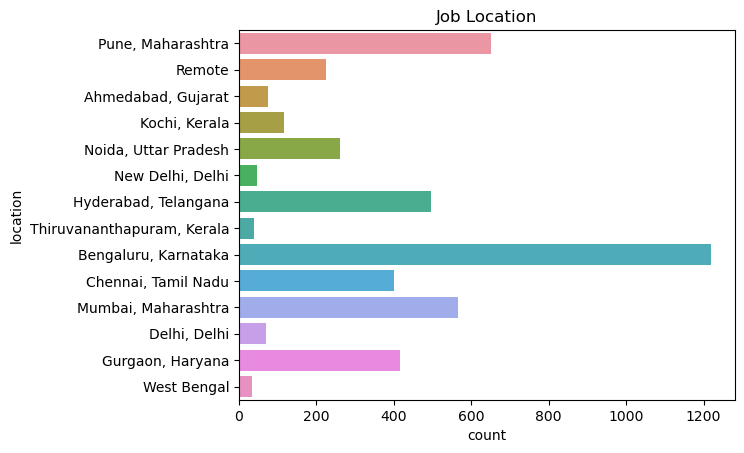

In [10]:
result_df = pd.read_csv(PROCESSEDOUTPUTFILE)
sns.countplot(y='location', data=result_df, width=0.8)
plt.title('Job Location')
plt.show()

### Company Location Frequency Count Plot

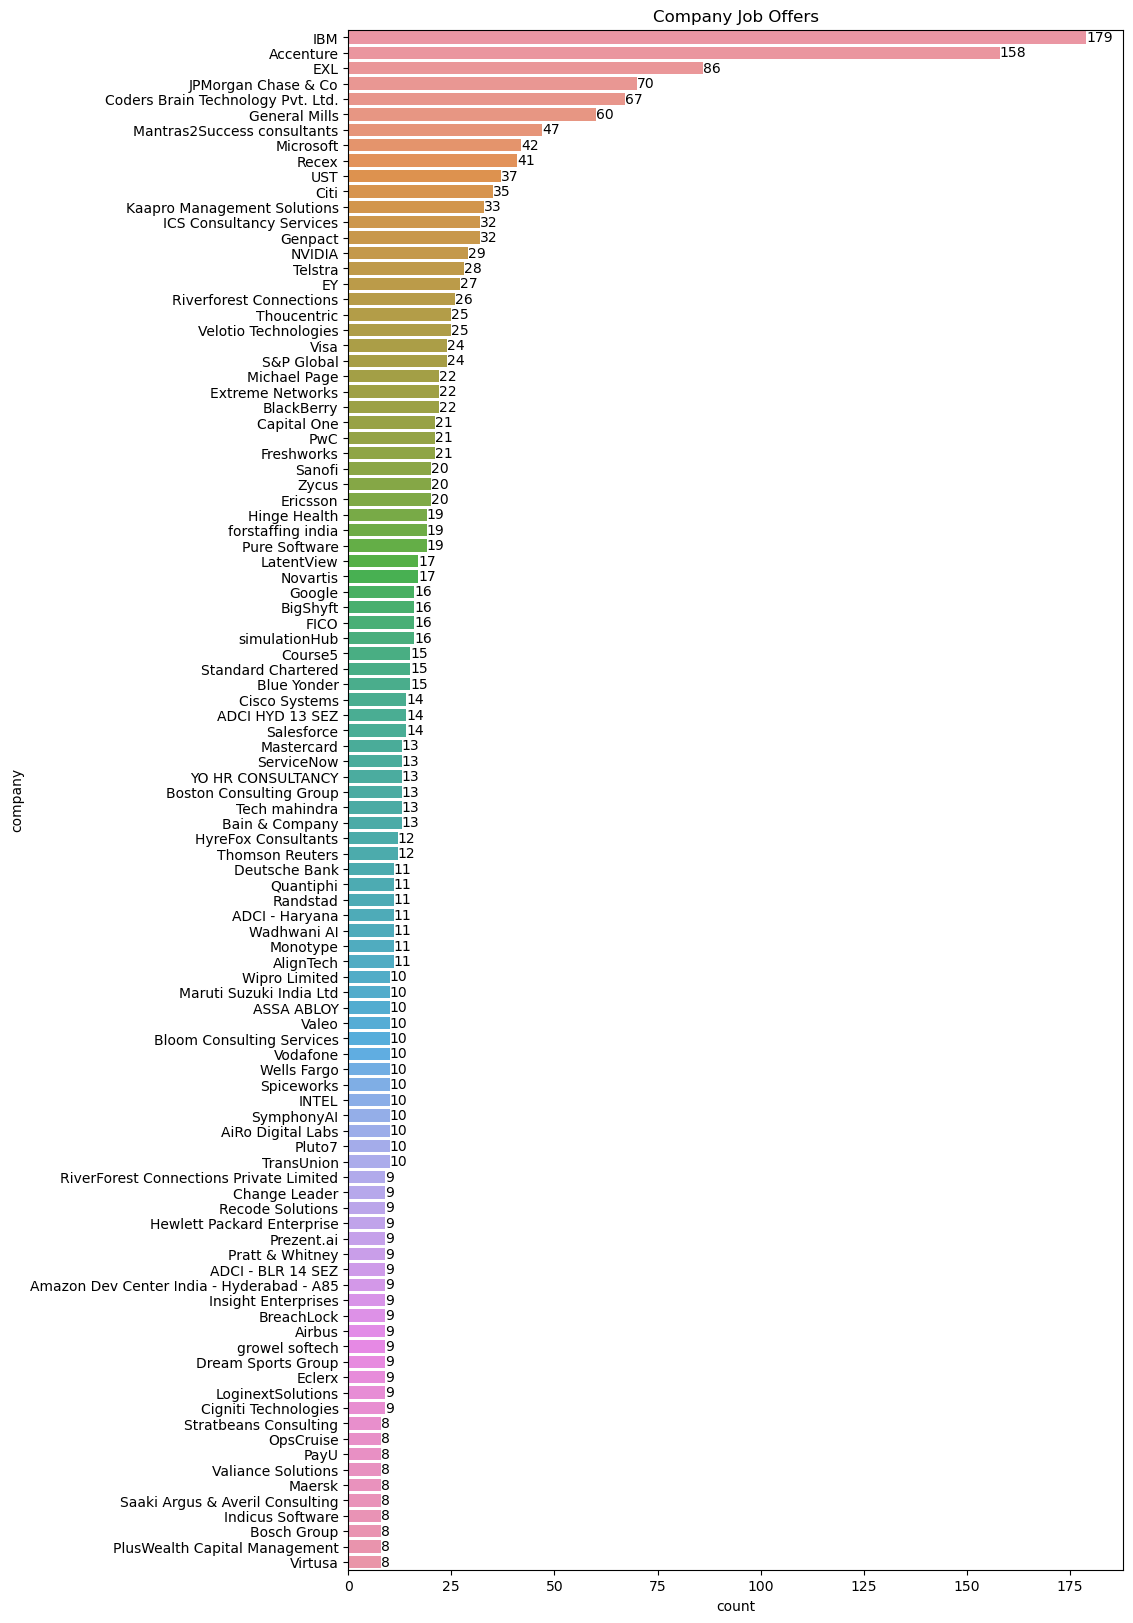

In [11]:
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(y='company', data=result_df, order=result_df.company.value_counts().iloc[:100].index, ax=ax)
ax.bar_label(ax.containers[0])
# sns.set(rc={'figure.figsize':(40.7,9.27)})
plt.title('Company Job Offers')
plt.show()

The IBM offers most of the jobs seconded by Accenture, EXL

### Job Type Frequency

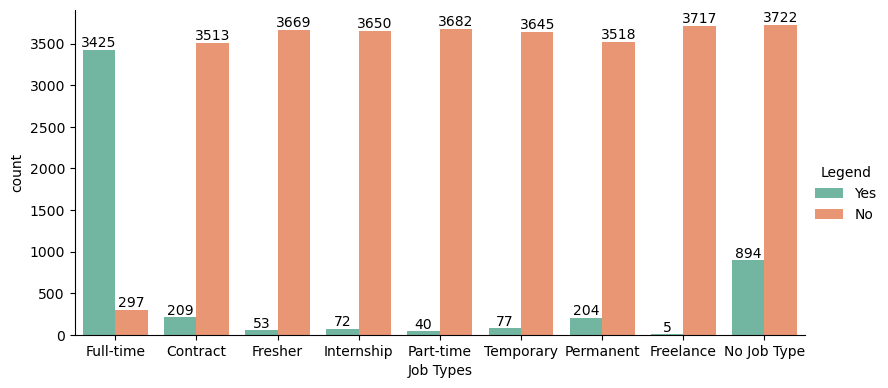

In [12]:
result_df = pd.read_csv(PROCESSEDOUTPUTFILE)
result_df_copy=result_df.copy()
job_types = ["Full-time", "Contract", "Fresher", "Internship", "Part-time", "Temporary", "Permanent", "Freelance"]
result_df_copy["No Job Type"] = result_df_copy[job_types].apply(lambda row: all(val == False for val in row), axis=1)
result_df_copy.loc[result_df_copy['No Job Type'], job_types] = np.nan
job_types.append("No Job Type")
df_long = result_df_copy.melt(value_vars=job_types, value_name='Legend').replace({'Legend': {False: 'No', True: 'Yes', np.nan: "NA"}})
df_long.drop(df_long[df_long['Legend'] == "NA"].index, inplace=True)
g = sns.catplot(kind='count', data=df_long,
                x='variable', hue='Legend', palette='Set2', height=4, aspect=2)
g.set(xlabel='Job Types')
for ax in g.axes.flat:
    for bars in ax.containers:
        ax.bar_label(bars)
plt.subplots_adjust(left=0.07, bottom=0.15)
plt.show()
# df.drop(df[df['column_name'] == value].index, inplace=True)

#### Distribution of Job Types

In [13]:
import plotly.express as px
result_df = pd.read_csv(PROCESSEDOUTPUTFILE)
result_df_copy=result_df.copy()

job_types = ["Full-time", "Contract", "Fresher", "Internship", "Part-time", "Temporary", "Permanent", "Freelance"]
data = result_df_copy[job_types].value_counts(job_types).reset_index(name="count")
def create_type_combination_name(row):
    name = ""
    for job_type in job_types:
        if row[job_type]:
            if len(name) > 0:
                name += ", "
            name += job_type
    if len(name)== 0:
        name = "No Job Type"
    return name
data["Legend"] = data.apply(create_type_combination_name, axis=1)
data

Full-time  Contract  Fresher  Internship  Part-time  Temporary  Permanent  \
0        True     False    False       False      False      False      False   
1       False     False    False       False      False      False      False   
2       False     False    False       False      False      False       True   
3        True      True    False       False      False      False      False   
4        True     False    False       False      False      False       True   
5       False      True    False       False      False      False      False   
6        True     False     True       False      False      False      False   
7       False     False    False       False      False       True      False   
8        True     False    False        True      False      False      False   
9       False     False    False        True      False      False      False   
10      False     False    False       False       True      False      False   
11       True     False    False       False      False       True      False   
12       True     False    False       False       True       True      False   
13      False      True    False       False      False       True      False   
14       True     False    False       False       True      False      False   
15      False     False     True       False      False      False      False   
16       True      True    False       False      False       True      False   
17      False     False    False       False      False      False      False   
18      False     False    False       False       True      False       True   
19      False      True    False       False      False      False       True   
20       True     False     True        True      False      False      False   
21       True      True    False       False      False      False       True   
22      False     False    False       False      False       True       True   
23       True      True    False        True      False      False      False   
24       True      True    False       False      False       True       True   
25      False      True    False       False       True      False      False   
26       True      True    False       False       True       True      False   
27       True      True     True       False      False      False      False   
28       True      True    False       False       True      False      False   
29      False     False     True        True      False      False      False   
30       True     False    False        True      False      False       True   
31      False     False     True       False      False      False       True   
32      False     False     True       False       True      False      False   
33      False      True     True       False      False      False      False   
34      False      True    False       False       True       True      False   
35       True      True     True        True      False      False      False   

    Freelance  count                                     Legend  
0       False   3129                                  Full-time  
1       False    894                                No Job Type  
2       False    135                                  Permanent  
3       False    128                        Full-time, Contract  
4       False     48                       Full-time, Permanent  
5       False     45                                   Contract  
6       False     35                         Full-time, Fresher  
7       False     35                                  Temporary  
8       False     33                      Full-time, Internship  
9       False     29                                 Internship  
10      False     13                                  Part-time  
11      False     11                       Full-time, Temporary  
12      False      9            Full-time, Part-time, Temporary  
13      False      8                        Contract, Temporary  
14      False   

###### Top types of jobs

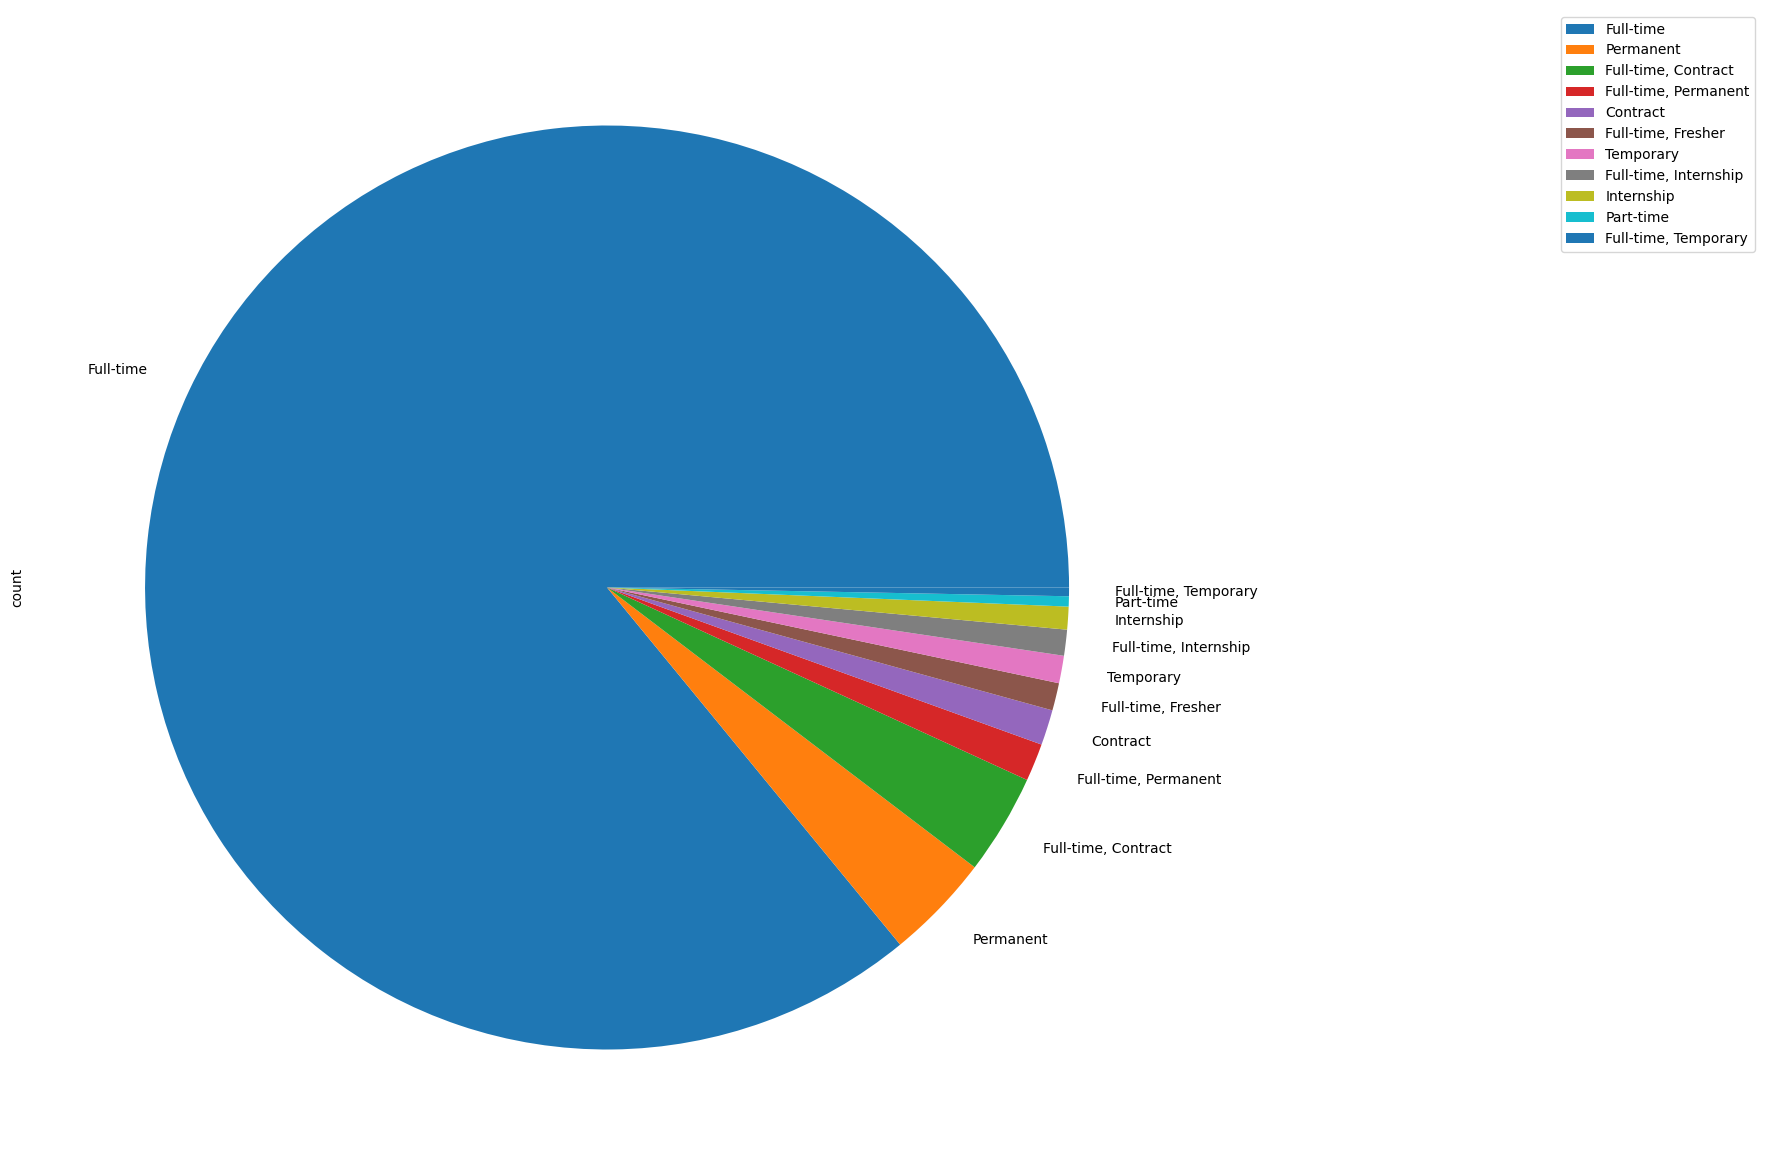

In [15]:
data = data[data["Legend"] != "No Job Type"]
data = data[data["count"] > 10]
result = data[["Legend", "count"]].set_index("Legend")
fig, ax = plt.subplots(figsize=(400, 15))
plot = result.plot.pie(y='count', ax=ax)
ax = plot.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

#### Programming Languages Frequency

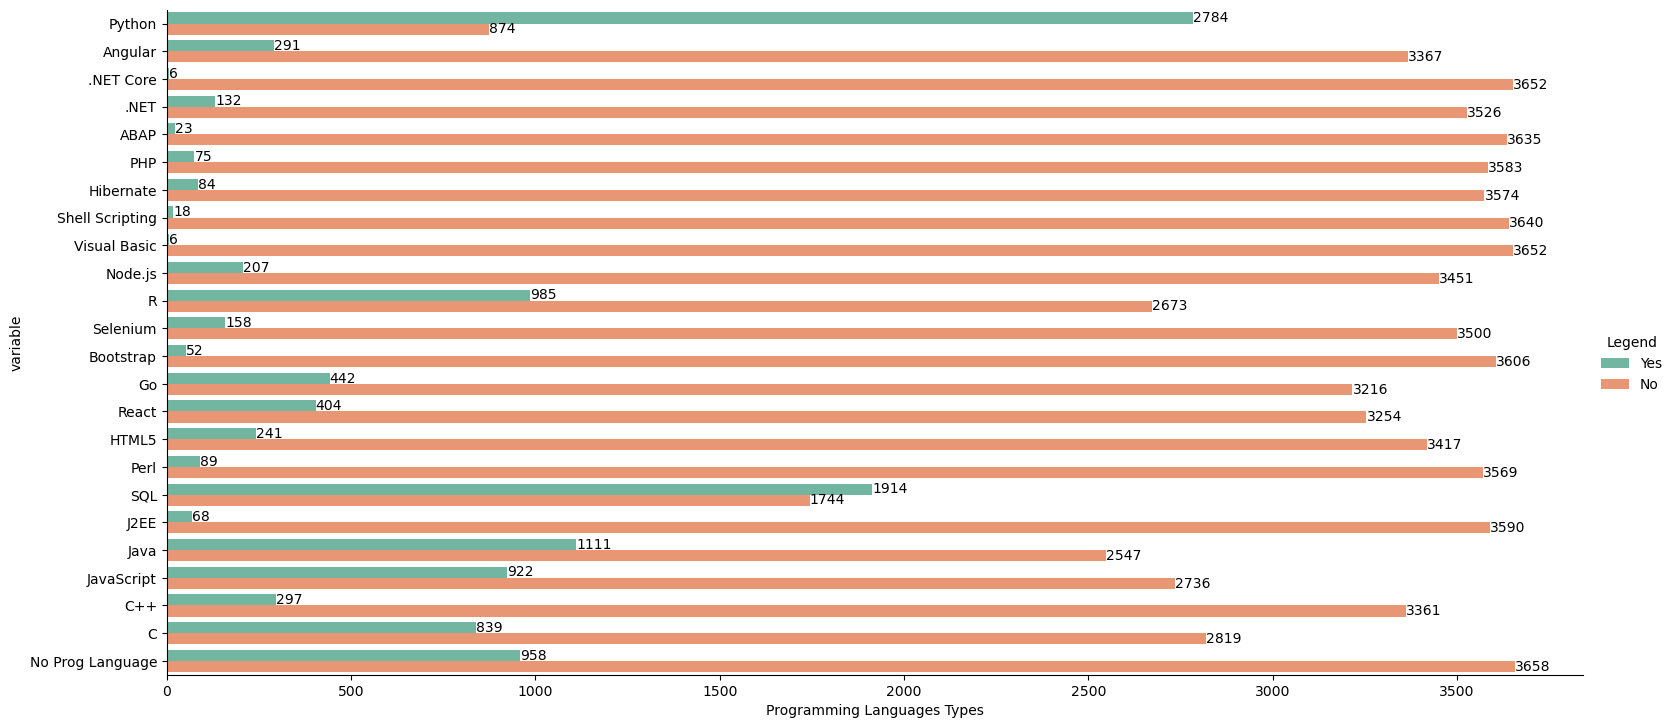

In [16]:
result_df_copy=result_df.copy()
programming_languages_types = ["Python", "Angular", ".NET Core", ".NET", "ABAP", "PHP", "Hibernate", "Shell Scripting", "Visual Basic", 
             "Node.js", "R", "Selenium", "Bootstrap", "Go", "React", "HTML5", "Perl", "SQL", "J2EE", "Java", "JavaScript", 
             "C++", "C"]
result_df_copy["No Prog Language"] = result_df_copy[programming_languages_types].apply(lambda row: all(val == False for val in row), axis=1)
result_df_copy.loc[result_df_copy['No Prog Language'], programming_languages_types] = np.nan
programming_languages_types.append("No Prog Language")
df_long = result_df_copy.melt(value_vars=programming_languages_types, value_name='Legend').replace({'Legend': {False: 'No', True: 'Yes', np.nan: "NA"}})
df_long.drop(df_long[df_long['Legend'] == "NA"].index, inplace=True)
g = sns.catplot(kind='count', data=df_long,
                y='variable', hue='Legend', palette='Set2', height=8, aspect=2)
g.set(xlabel='Programming Languages Types')
for ax in g.axes.flat:
    for bars in ax.containers:
        ax.bar_label(bars)
plt.subplots_adjust(left=0.1, bottom=0.15)
plt.show()

#### Salary Analysis

In [51]:
result_df_copy=result_df.copy()
result_df_copy = result_df_copy[result_df_copy['normalised_yearly_salary'].notna()]
result_df_copy.shape, result_df.shape

((714, 46), (4616, 46))

We can see for 714 Jobs we were able to extract Salary. 

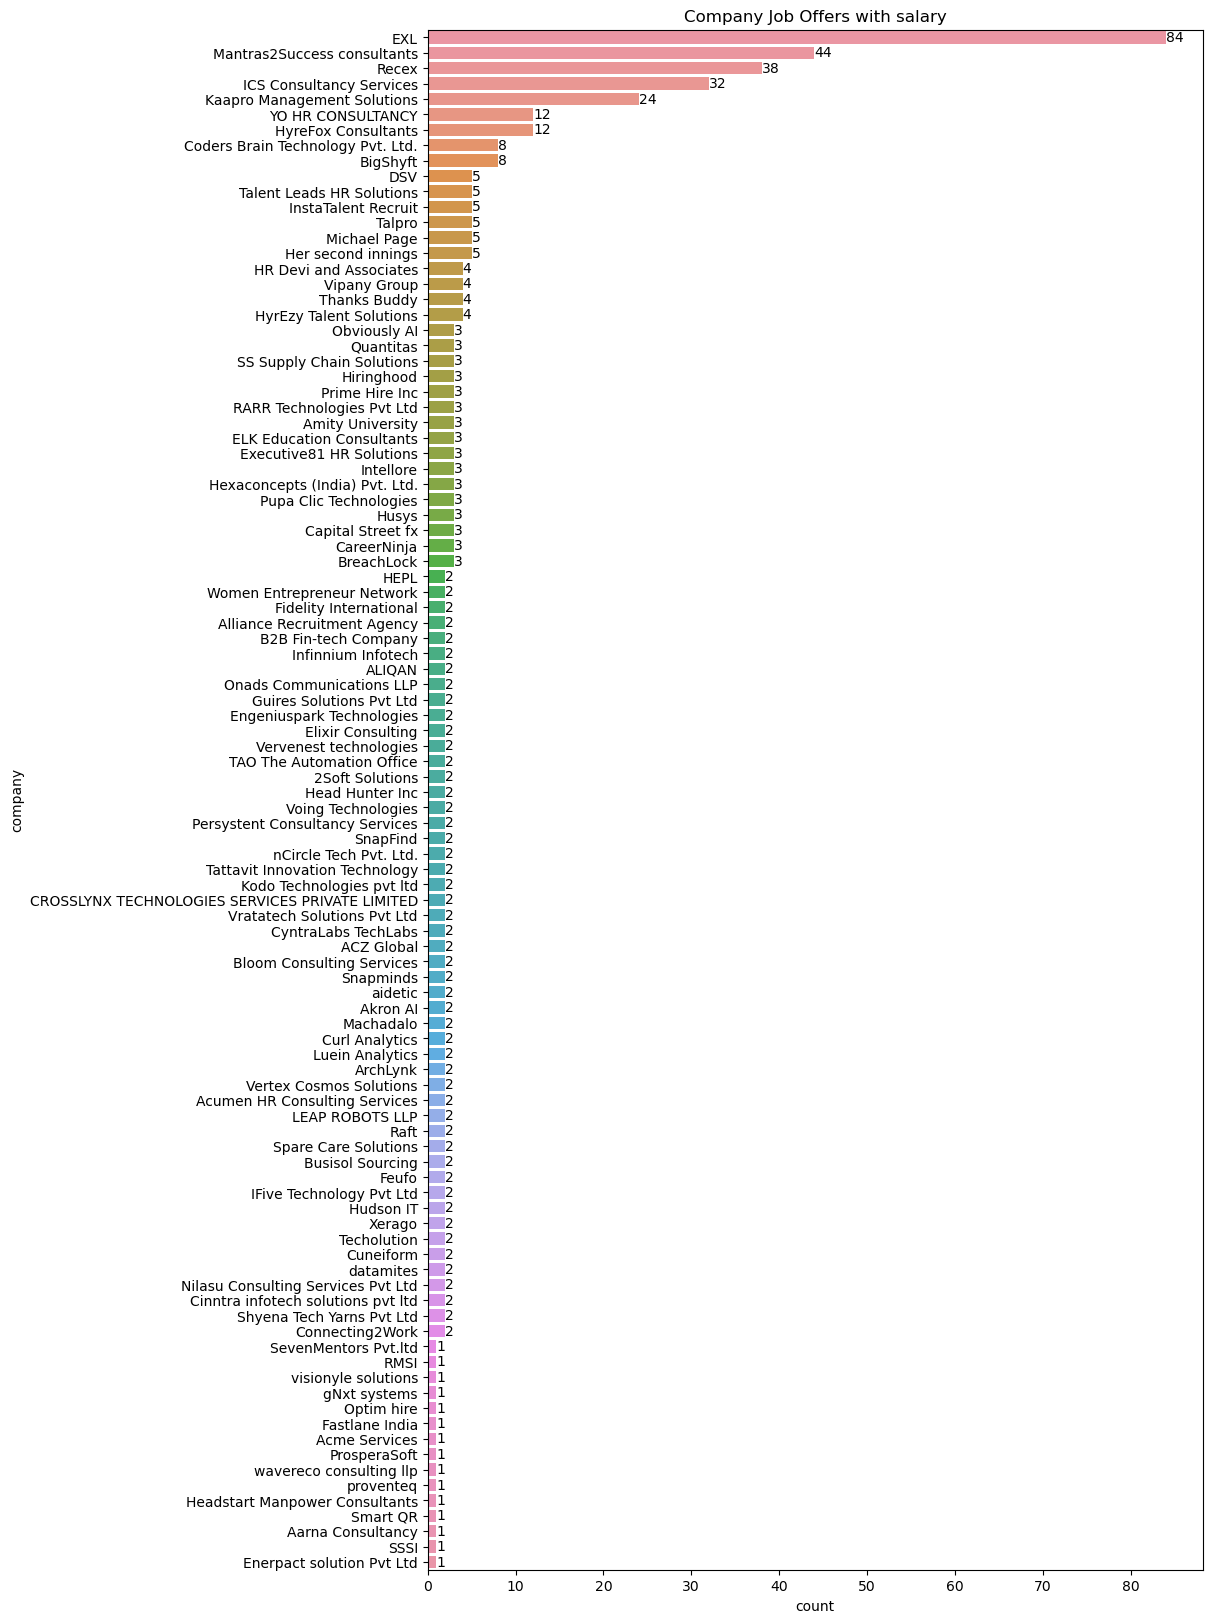

In [105]:
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(y='company', data=result_df_copy, order=result_df_copy.company.value_counts().iloc[:100].index, ax=ax)
ax.bar_label(ax.containers[0])
# sns.set(rc={'figure.figsize':(40.7,9.27)})
plt.title('Company Job Offers with salary')
plt.show()

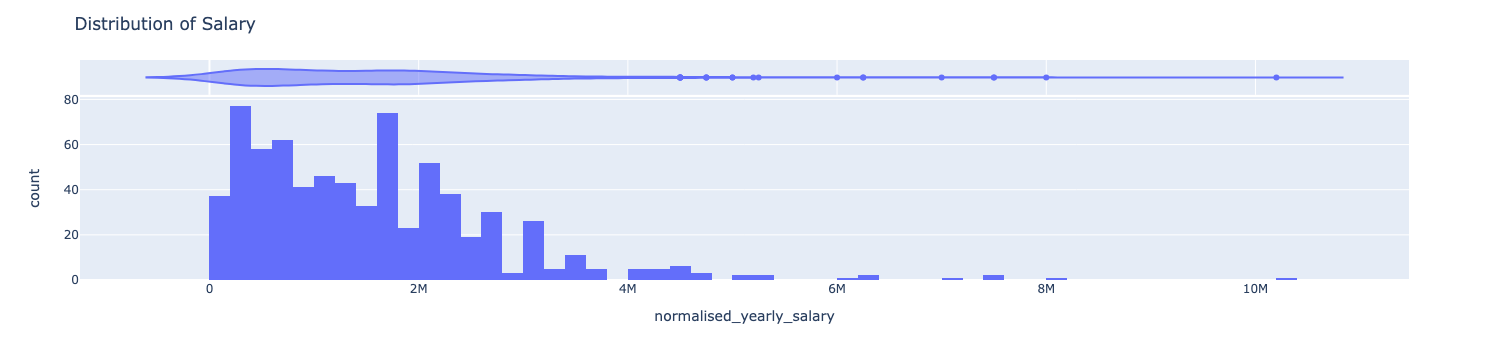

In [74]:
import plotly.express as px
fig = px.histogram(result_df_copy, x='normalised_yearly_salary', nbins=100, marginal='violin')
fig.update_layout(title='Distribution of Salary')
fig.show()

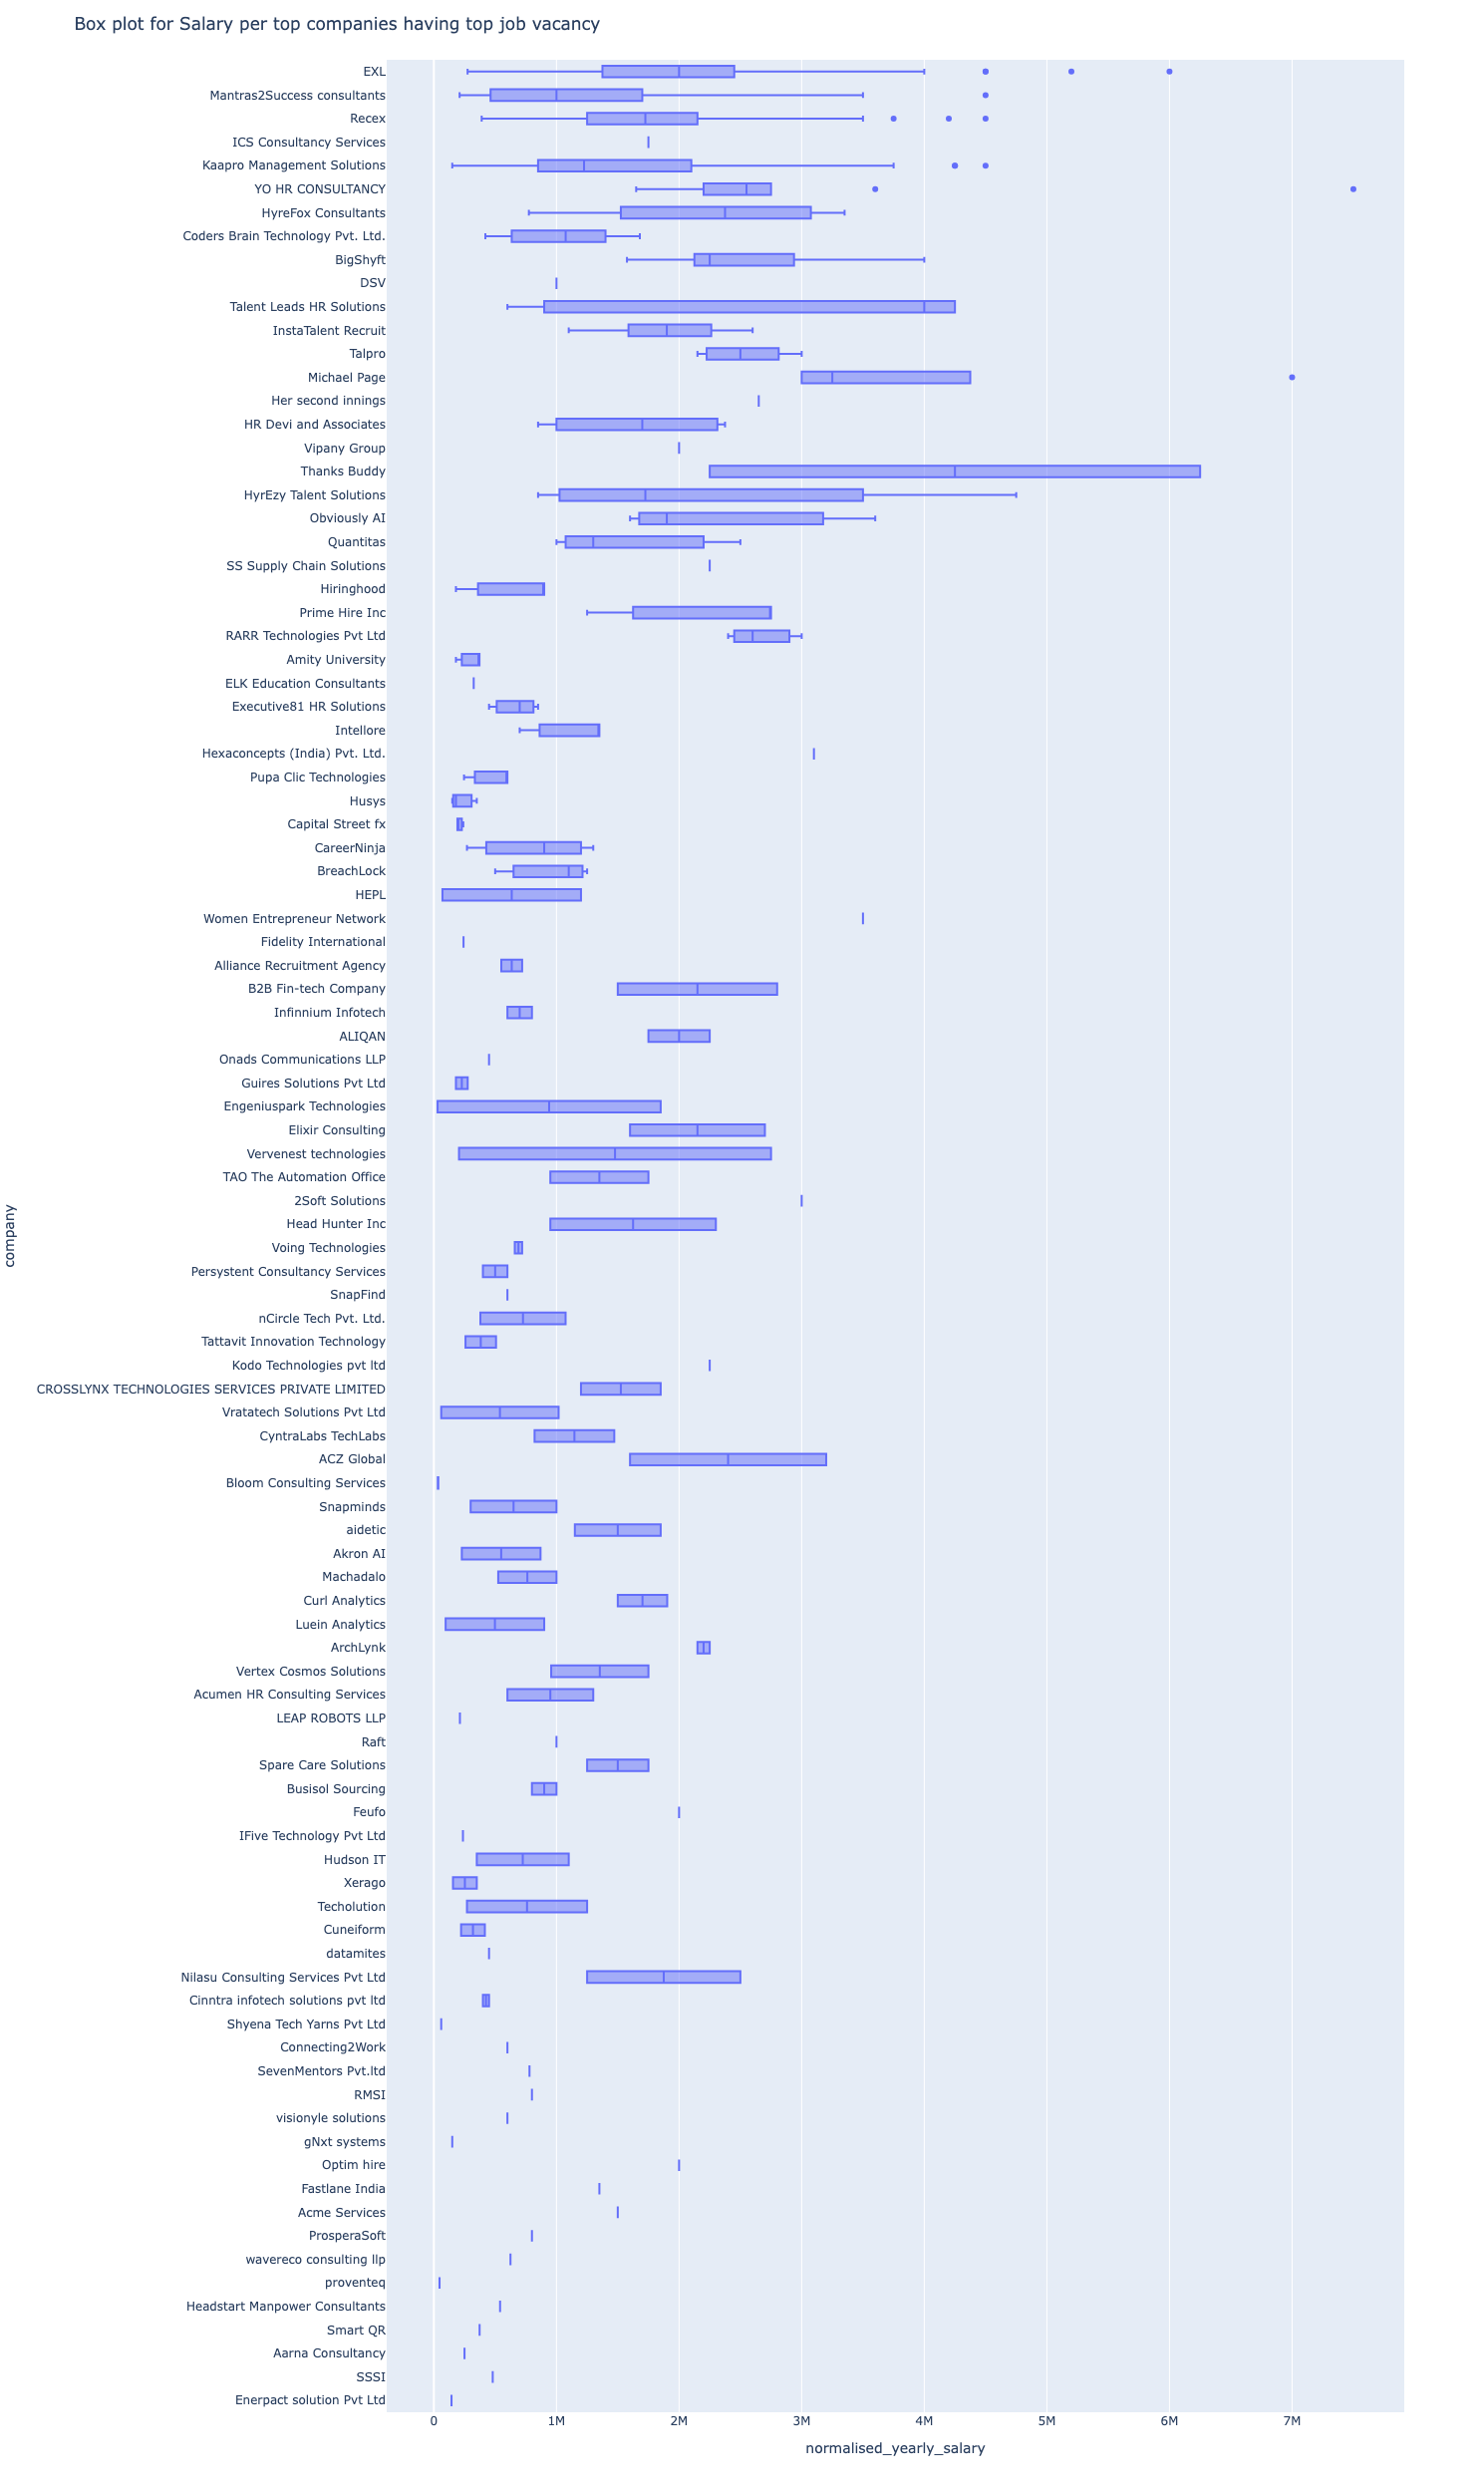

In [108]:
import plotly.express as px

result_df_copy.company.value_counts().iloc[:100].index
fig = px.box(result_df_copy[result_df_copy["company"].isin(result_df_copy.company.value_counts().iloc[:100].index)],
             x='normalised_yearly_salary', y='company',
            category_orders={'company':result_df_copy.company.value_counts().iloc[:100].index})
fig.update_layout(width=1100, height=2500, title="Box plot for Salary per top companies having top job vacancy")
fig.show()

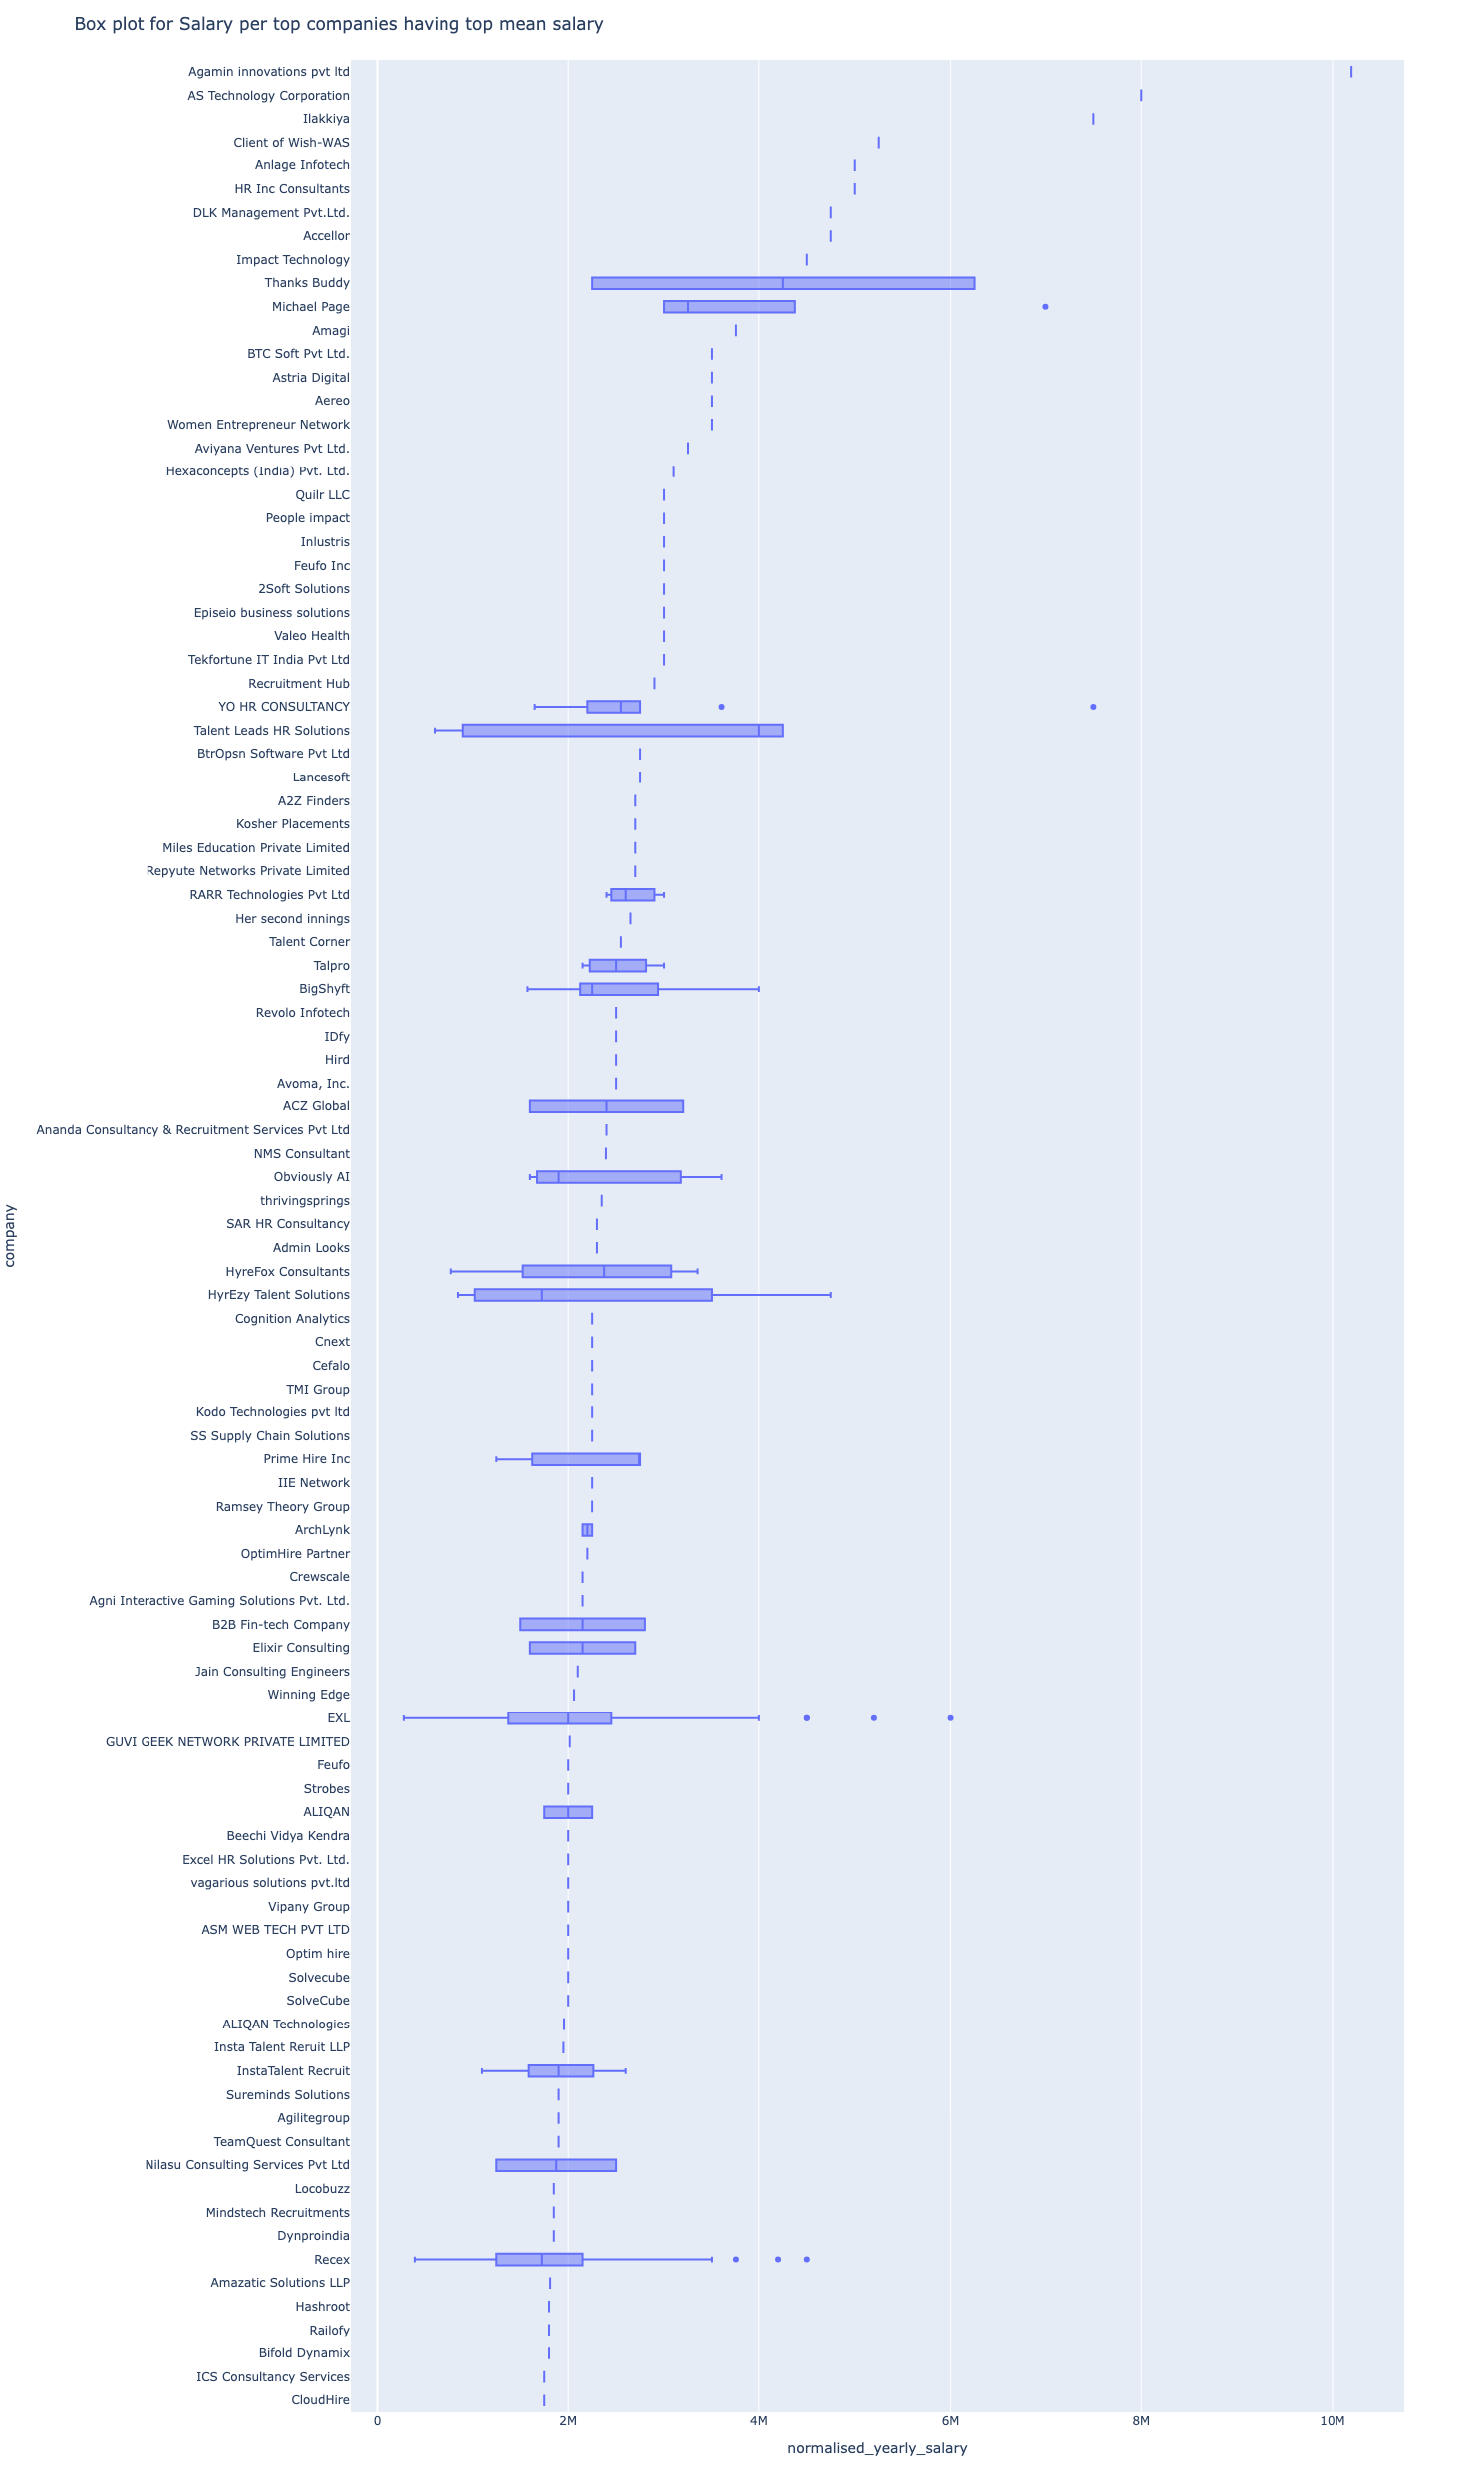

In [118]:
df_by_spec_count = result_df_copy.groupby('company').agg({"normalised_yearly_salary": ['mean', 'count'], 'company': 'first'})
df_by_spec_count.columns = df_by_spec_count.columns.droplevel(0)
df_by_spec_count = df_by_spec_count.sort_values(by='mean', ascending=False)

fig = px.box(result_df_copy[result_df_copy["company"].isin(df_by_spec_count["first"].iloc[:100].index)],
             x='normalised_yearly_salary', y='company',hover_data=['company'],
            category_orders={'company' : df_by_spec_count["first"].iloc[:100].index})
fig.update_layout(width=1100, height=2500, title="Box plot for Salary per top companies having top mean salary")
fig.show()

#### Locations vs Salary

In [ ]:
job_types = ["Full-time", "Contract", "Fresher", "Internship", "Part-time", "Temporary", "Permanent", "Freelance"]
result_df_copy=result_df.copy()
df = result_df_copy[['location', *job_types]]
df['location'] = df['location'].astype('category')
g = sns.PairGrid(df, hue='location', palette='viridis', vars=job_types)
g.map(sns.histplot)
g.add_legend()
plt.show()

In [219]:
# g = sns.catplot(kind='count', data=df_long,
#                 x='location', hue='location', palette='Set2', height=4, aspect=2)
# result_df_copy["No Job Type"] = result_df_copy[job_types].apply(lambda row: all(val == False for val in row), axis=1)
# result_df_copy.loc[result_df_copy['No Job Type'], job_types] = np.nan
# job_types.append("No Job Type")
# df_long = result_df_copy.melt(value_vars=job_types, value_name='Legend').replace({'Legend': {False: 'No', True: 'Yes', np.nan: "NA"}})
# df_long.drop(df_long[df_long['Legend'] == "NA"].index, inplace=True)
# g = sns.catplot(kind='count', data=df_long,
#                 x='variable', hue='Legend', palette='Set2', height=4, aspect=2)
# g.set(xlabel='Job Types')
# 
# plt.subplots_adjust(left=0.07, bottom=0.15)
# plt.show()
# fig, ax = plt.subplots(figsize=(100, 20))
df_melted = pd.melt(df, id_vars=['location'], value_vars=job_types, var_name='Job Type', value_name='Count').replace({'Count': {False: 0, True: 1}})
# g = sns.barplot(data=df_melted, x='location',
#                 y='Count', hue='Job Type', ax=ax)
# _ = g.set(xlabel='Count')
# # Get the bar objects
# bars = ax.containers[0]
df_melted

location   Job Type  Count
0         Pune, Maharashtra  Full-time      0
1         Pune, Maharashtra  Full-time      1
2                    Remote  Full-time      1
3        Ahmedabad, Gujarat  Full-time      0
4             Kochi, Kerala  Full-time      0
...                     ...        ...    ...
36923  Noida, Uttar Pradesh  Freelance      0
36924  Bengaluru, Karnataka  Freelance      0
36925   Mumbai, Maharashtra  Freelance      0
36926  Bengaluru, Karnataka  Freelance      0
36927  Bengaluru, Karnataka  Freelance      0

[36928 rows x 3 columns]

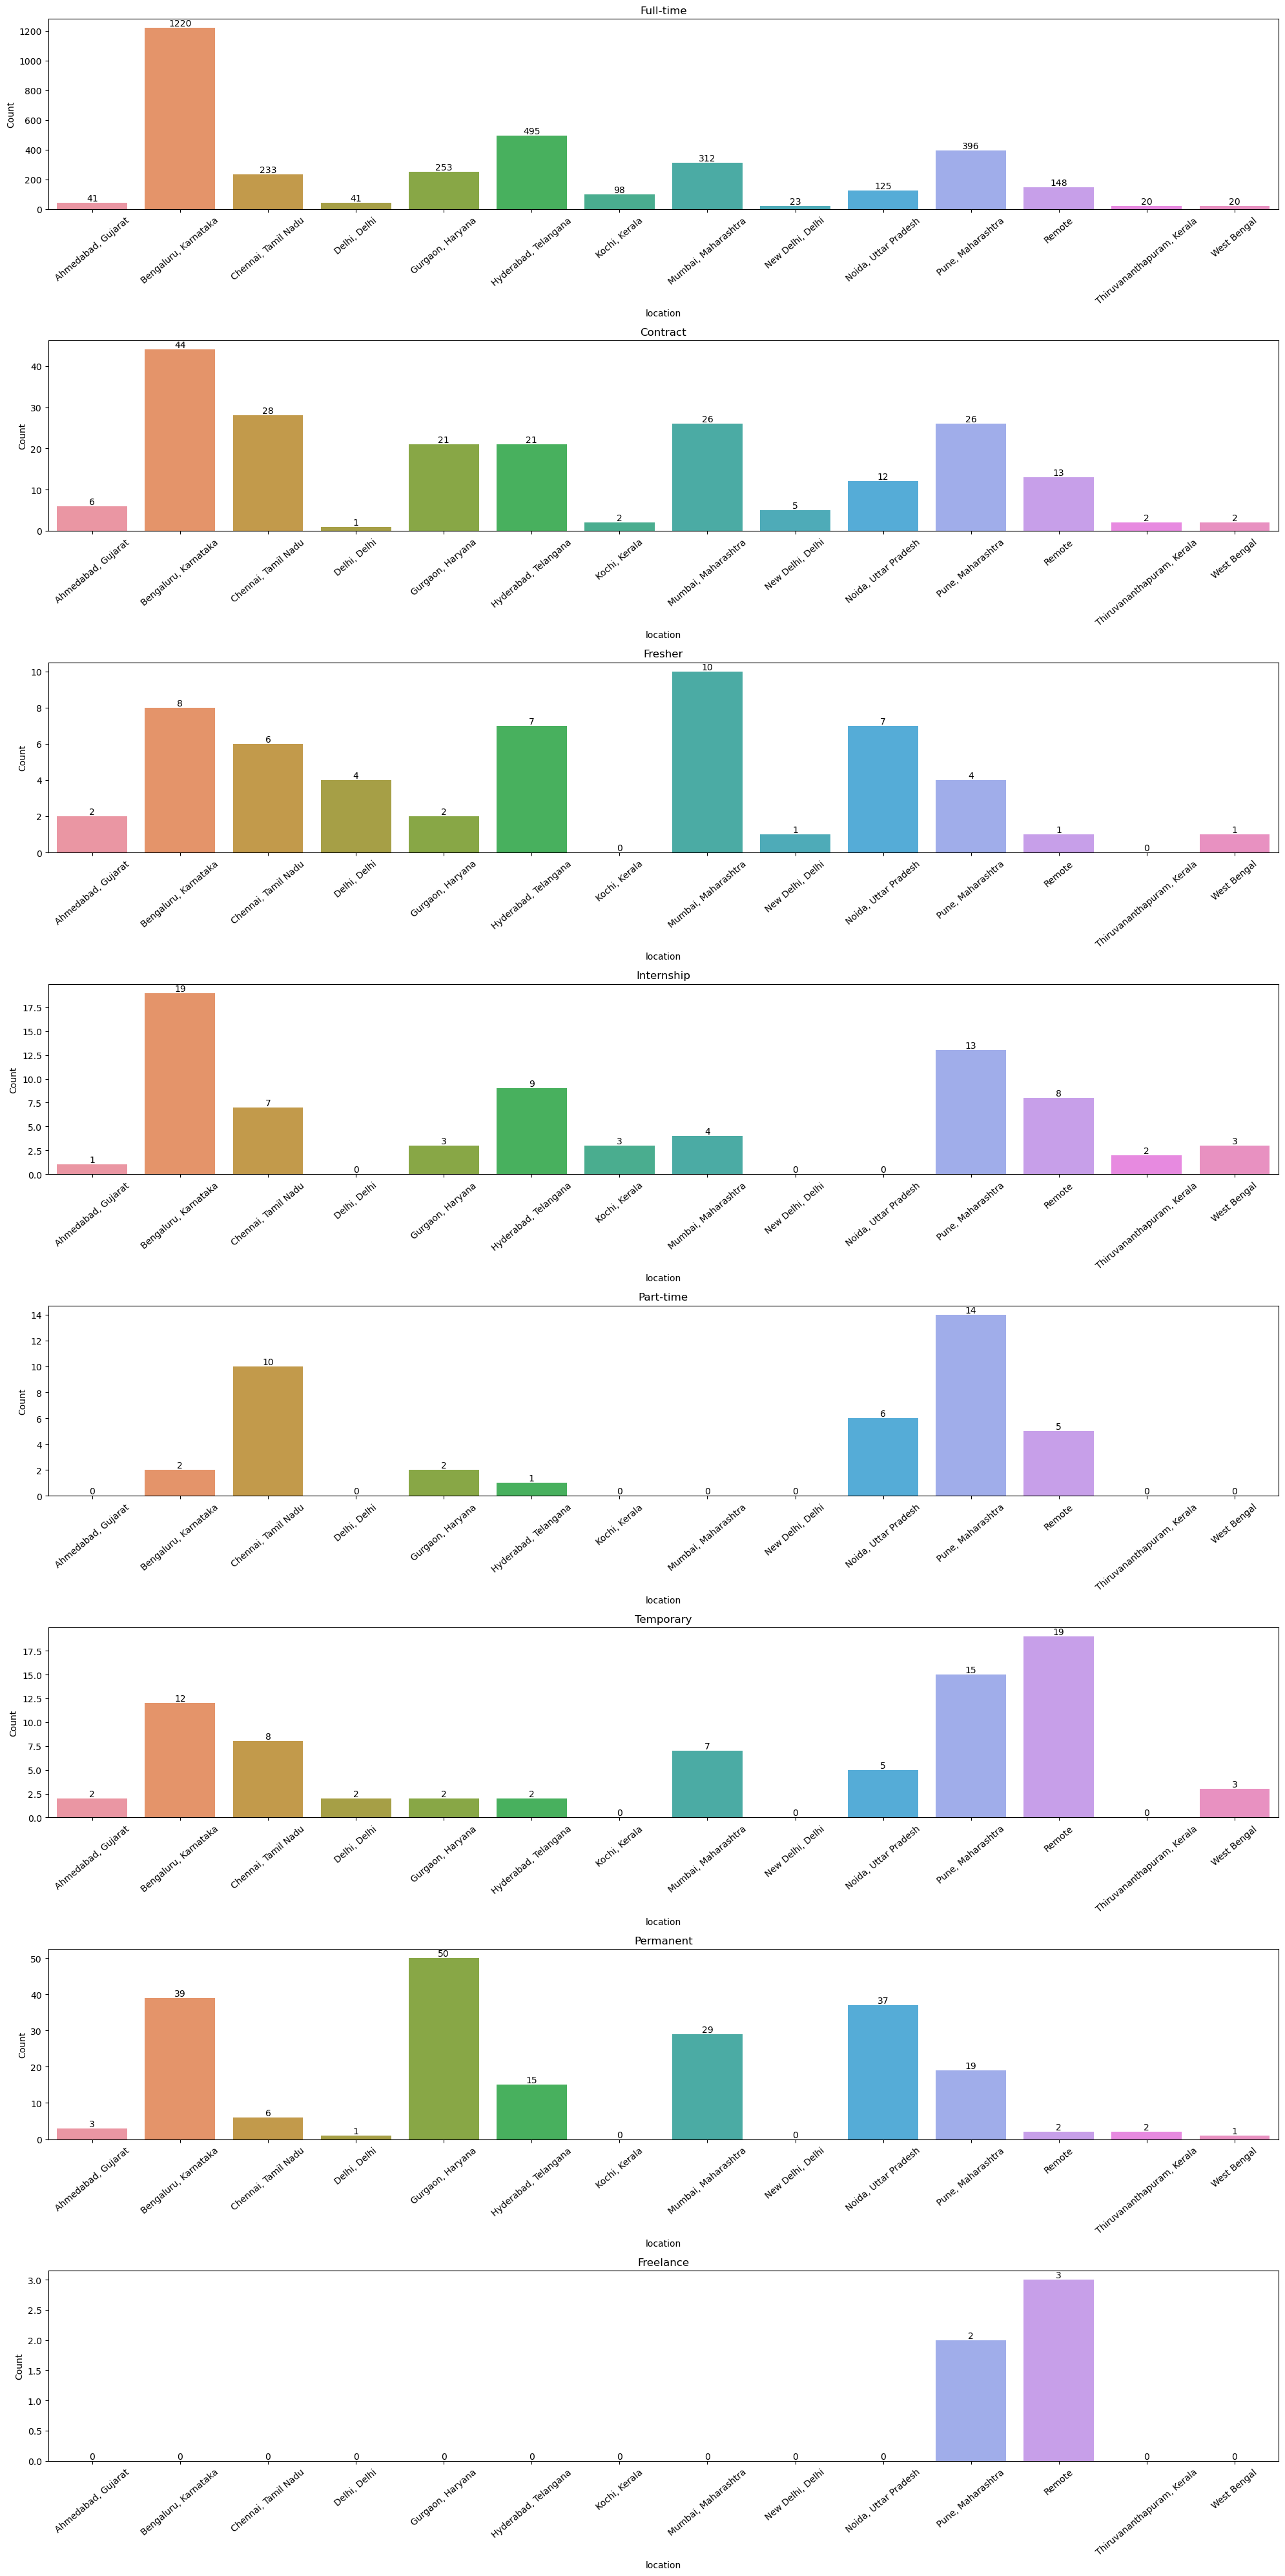

In [223]:
# # Add labels to the bars
# ax.bar_label(bars)
# for bars in ax.containers:
#     ax.bar_label(bars)
import matplotlib.ticker as ticker
fig, ax = plt.subplots(8, 1,figsize=(20,40))
ax = ax.flatten()
for i, job_type in enumerate(job_types):
    sns.barplot(x="location",y="Count",data=df_melted[df_melted["Job Type"] == job_type],ax=ax[i],errorbar=None, estimator=sum)
    ax[i].xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax[i].tick_params(axis='x', rotation=40)
    ax[i].set_title(job_type)
    for bars in ax[i].containers:
        ax[i].bar_label(bars)
plt.tight_layout()
plt.show()
# sns.barplot(x="location",y="Count",data=tips,ax=ax[1],ci=None)
# ax[1].xaxis.set_major_locator(ticker.MultipleLocator(1))

#### Job Titles

In [478]:
result_df_copy=result_df.copy()

In [509]:
import re
import string
import nltk
# Download the "punkt" resource
nltk.download('punkt')
# Download the "stopwords" resource
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



def clean_text(text):
    # Convert text to lowercase
    text_lower = text.lower()

    # Remove punctuation and unwanted characters using regular expressions
    text_cleaned = re.sub(r'[^\w\s]', '', text_lower)

    # Tokenize the text into individual words
    words = word_tokenize(text_cleaned)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words_filtered = [word for word in words if word not in stop_words]

    # Lemmatize the words to their base form
    lemmatizer = WordNetLemmatizer()
    words_lemmatized = [lemmatizer.lemmatize(word) for word in words_filtered]
    to_remove = ['sr', 'senior']
    to_replace = {'ml': 'machine learning', 
                  'sr': 'senior',
                  'ai': 'artificial intelligence', 
                  'aiml': 'artificial intelligence machine learning', 
                  'mlai': 'machine learning artificial intelligence'
                 }
    words_lemmatized_processed = []
    for word in words_lemmatized:
        skip = False
        for word1 in to_replace:
            if word in to_remove:
                skip = True
                break
            if word == word1:
                word = to_replace[word1]
        if not skip:
            words_lemmatized_processed.append(word)
    # Join the cleaned and lemmatized words back into a clean text
    cleaned_text = ' '.join(words_lemmatized_processed)
    return cleaned_text
result_df_copy["processes_job_title"] = result_df_copy["job_title"].apply(clean_text)
# print(result_df_copy.job_title.unique().shape)
# g = set()
# for x in result_df_copy.job_title.unique():
#     g.add(clean_text(x))
# print(g)
categories = ["software engineer", "machine learning engineer", "artificial intelligence engineer","quality assurance engineer",  "test", 
              "full stack developer",  "automation engineer", "data scientist", "technical architect",
              "data science", "artificial intelligence", "machine learning",  "data analyst", "data architect",
              "solution architect", "business development", "developer", 
              "engineer", "manager", "consult", "database", "architect", "scientist", "research", "software", "market",  "vice president", "devops", "backend" 
              "director", "support", "business", "officer", "lead", "qa"]
def get_generalised_category(title):
    for x in categories:
        if x in title:
            if x == "qa":
                return "Quality Assurance"
            return x
        if "datascience" in title:
            return "data science"
        if "analyst" in title or "analytics" in title or "analytical" in title:
            return "analyst"
        if "technical" in title or "tech" in title or "technology" in title:
            return "technology or technical"
        if "uiux" in title or "ui" in title or "ux" in title or "uxui" in title or "graphic" in title:
            return "UI"
    return "other"
result_df_copy["job_title_category"] = result_df_copy["processes_job_title"].apply(get_generalised_category)

[nltk_data] Downloading package punkt to /Users/lngeorge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lngeorge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lngeorge/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [510]:
pd.reset_option('all')
pd.set_option('display.max_columns', None)
result_df_copy.head()

/var/folders/fq/t1vhfgh95v33mglpnsqgnyyh0000gq/T/ipykernel_25065/4062869347.py:1: FutureWarning:

column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.

/var/folders/fq/t1vhfgh95v33mglpnsqgnyyh0000gq/T/ipykernel_25065/4062869347.py:1: FutureWarning:

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

/var/folders/fq/t1vhfgh95v33mglpnsqgnyyh0000gq/T/ipykernel_25065/4062869347.py:1: FutureWarning:


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.




job_title                      company  \
0              (Machine Learning Engineer  Alliance Recruitment Agency   
1                 (Senior) Data Scientist                  Verve Group   
2                   . Lead Data Scientist               Prime Hire Inc   
3               .NET + Power BI Developer                        7Span   
4  .NET Developer 1-3 years of experience                    Zine Mind   

             location                       date  \
0   Pune, Maharashtra  PostedPosted 30+ days ago   
1   Pune, Maharashtra    PostedPosted 3 days ago   
2              Remote   PostedPosted 21 days ago   
3  Ahmedabad, Gujarat   PostedPosted 24 days ago   
4       Kochi, Kerala  PostedPosted 30+ days ago   

                                            job_desc  \
0  Proficiency with Python and basic libraries fo...   
1  Fluent in statistical analysis, data mining, a...   
2   A Master’s degree in machine learning, mathe...   
3  Experience with advanced analytics and machine...   
4  .NET Developer1-3 years of experience.\nLookin...   

                                   metadata  rating  \
0                                       NaN     NaN   
1                                 Full-time     NaN   
2  ₹15,00,000 - ₹40,00,000 a year|Full-time     NaN   
3                                       NaN     NaN   
4                                       NaN     NaN   

                                                href  Full-time  Python  \
0  https://in.indeed.com/rc/clk?jk=e19b98250e2051...      False    True   
1  https://in.indeed.com/rc/clk?jk=97f4cb8264c100...       True    True   
2  https://in.indeed.com/rc/clk?jk=2b770535de1809...       True    True   
3  https://in.indeed.com/rc/clk?jk=3be91ff7a4fff6...      False   False   
4  https://in.indeed.com/rc/clk?jk=e42e2a672989f1...      False   False   

   Angular  .NET Core   .NET   ABAP    PHP  Hibernate  Shell Scripting  \
0    False      False  False  False  False      False            False   
1    False      False  False  False  False      False            False   
2    False      False  False  False  False      False            False   
3    False      False  False  False  False      False            False   
4    False      False  False  False  False      False            False   

   Visual Basic  Node.js      C      R  Selenium  Bootstrap     Go  React  \
0         False    False  False  False     False      False  False  False   
1         False    False  False  False     False      False  False  False   
2         False    False  False   True     False      False  False  False   
3         False    False   True  False     False      False  False  False   
4         False    False   True  False     False      False  False  False   

   HTML5   Perl    SQL   J2EE   Java  JavaScript    C++  Contract  Fresher  \
0  False  False  False  False  False       False  False     False    False   
1  False  False   True  False   True       False  False     False    False   
2  False  False  False  False  False       False  False     False    False   
3  False  False   True  False  False       False  False     False    False   
4  False  False   True  False  False       False  False     False    False   

   Internship  Part-time  Temporary  \
0       False      False      False   
1       False      False      False   
2       False      False      False   
3       False      False      False   
4       False      False      False   

                                         Description  \
0  \n\n\n\n   2-10 Years\n  \n\n\n    Pune\n  \n\...   
1  \nWho We Are\n Verve Group’s omnichannel ad pl...   
2  Exp: 5+Yrs in Data Science (Minimum 2 Years of...   
3  \n\nAbout 7Span:\n\n\n\n\n     We are a passio...   
4  \n\n\n.NET Developer1-3 years of experience\n ...   

                    salary_string  average_salary  min_salary  max_salary  \
0                             NaN             NaN         NaN         NaN   
1                             NaN             NaN   

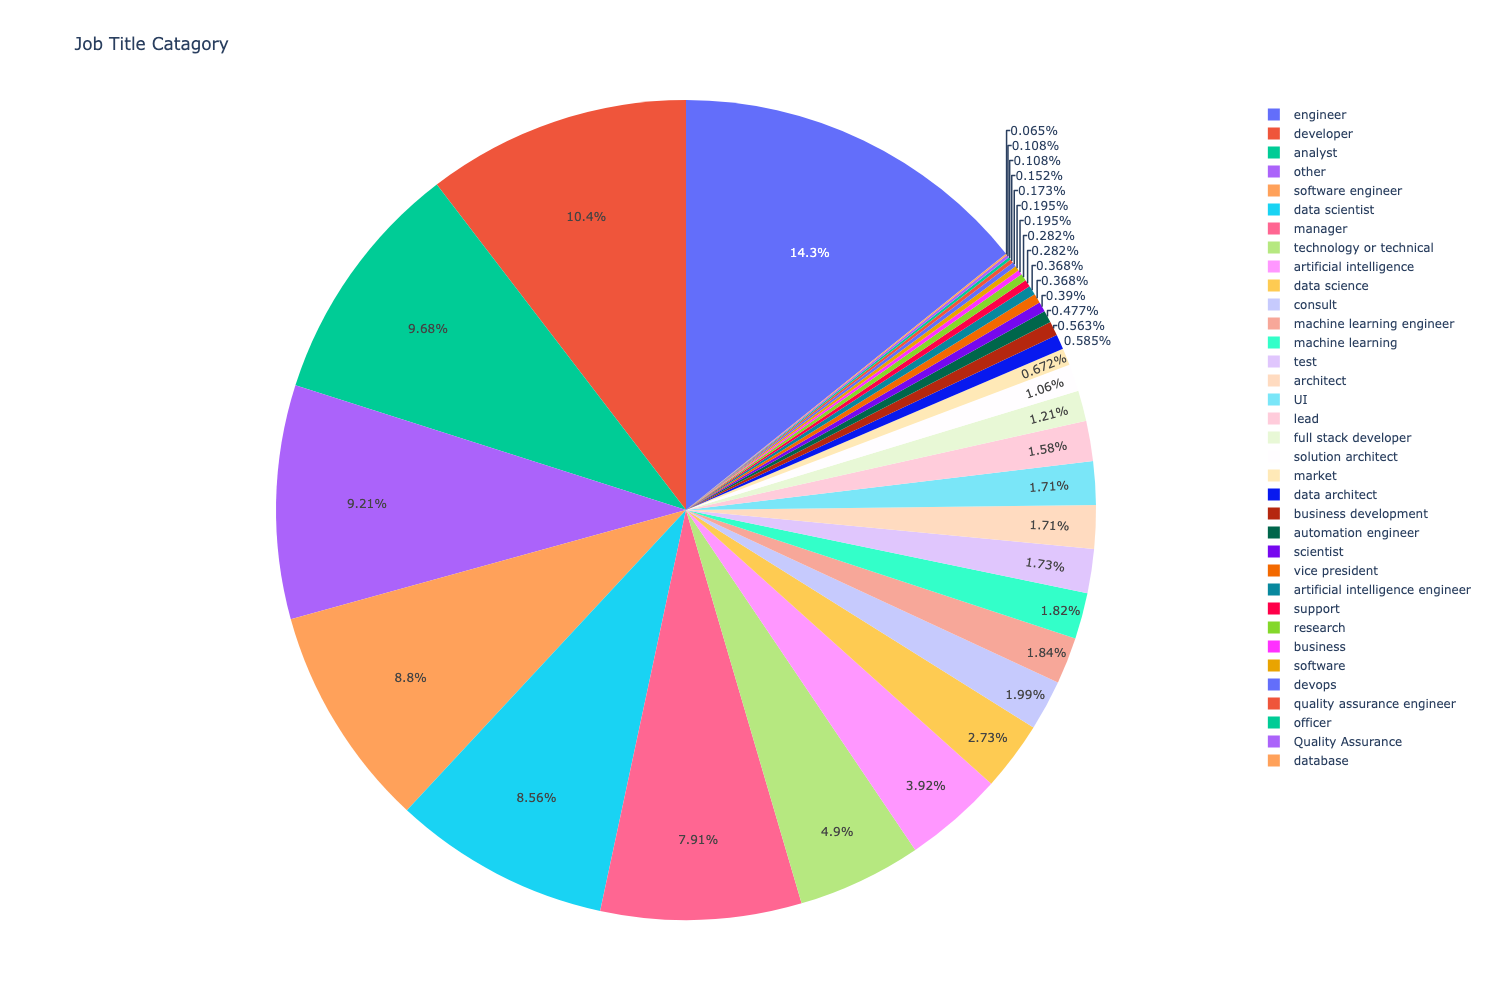

In [511]:
import plotly.express as px
counts = result_df_copy.job_title_category.value_counts()
fig = px.pie(counts, names=counts.index, values=counts.values, title='Job Title Catagory', width=1000, height=1000)
fig.show()

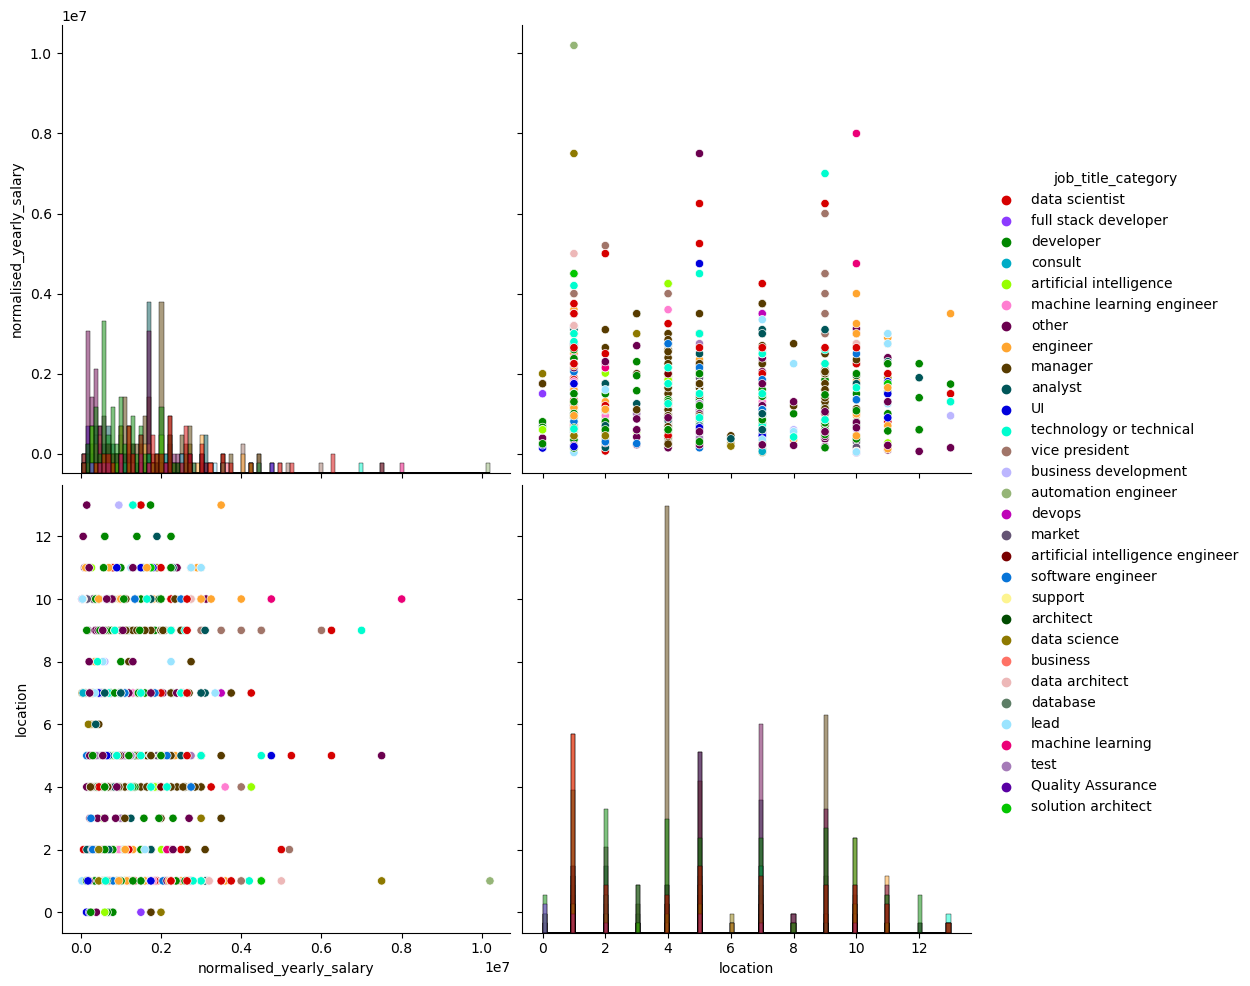

In [482]:
from sklearn.datasets import make_blobs
import colorcet as cc
import matplotlib.pyplot as plt
import seaborn as sns


blobs, labels = make_blobs(n_samples=1000, centers=30, center_box=(-100, 100))
palette = sns.color_palette(cc.glasbey, n_colors=30)

df = result_df_copy[["job_title_category", "normalised_yearly_salary", "location"]][result_df_copy["normalised_yearly_salary"].notna()]
# dictionary = dict(zip(df.job_title_category.unique(), series))
# df["job_title_category"] = df["job_title_category"].map(dictionary)
# df["job_title_category_code"] = df.job_title_category.astype('category').codes
df["location_category"] = df.location.astype('category')
df["location"] = df.location_category.cat.codes

# df = pd.get_dummies(df, columns=["job_title_category"], prefix="", prefix_sep='')
sns.pairplot(df[["job_title_category", "normalised_yearly_salary", "location"]], hue="job_title_category", palette=palette, 
             diag_kind="hist", diag_kws=dict(bins=100), height=5)

In [483]:
dict( zip( df['location_category'].cat.codes, df['location_category'] ))

{11: 'Remote',
 0: 'Ahmedabad, Gujarat',
 8: 'New Delhi, Delhi',
 10: 'Pune, Maharashtra',
 7: 'Mumbai, Maharashtra',
 1: 'Bengaluru, Karnataka',
 3: 'Delhi, Delhi',
 5: 'Hyderabad, Telangana',
 2: 'Chennai, Tamil Nadu',
 13: 'West Bengal',
 9: 'Noida, Uttar Pradesh',
 4: 'Gurgaon, Haryana',
 6: 'Kochi, Kerala',
 12: 'Thiruvananthapuram, Kerala'}

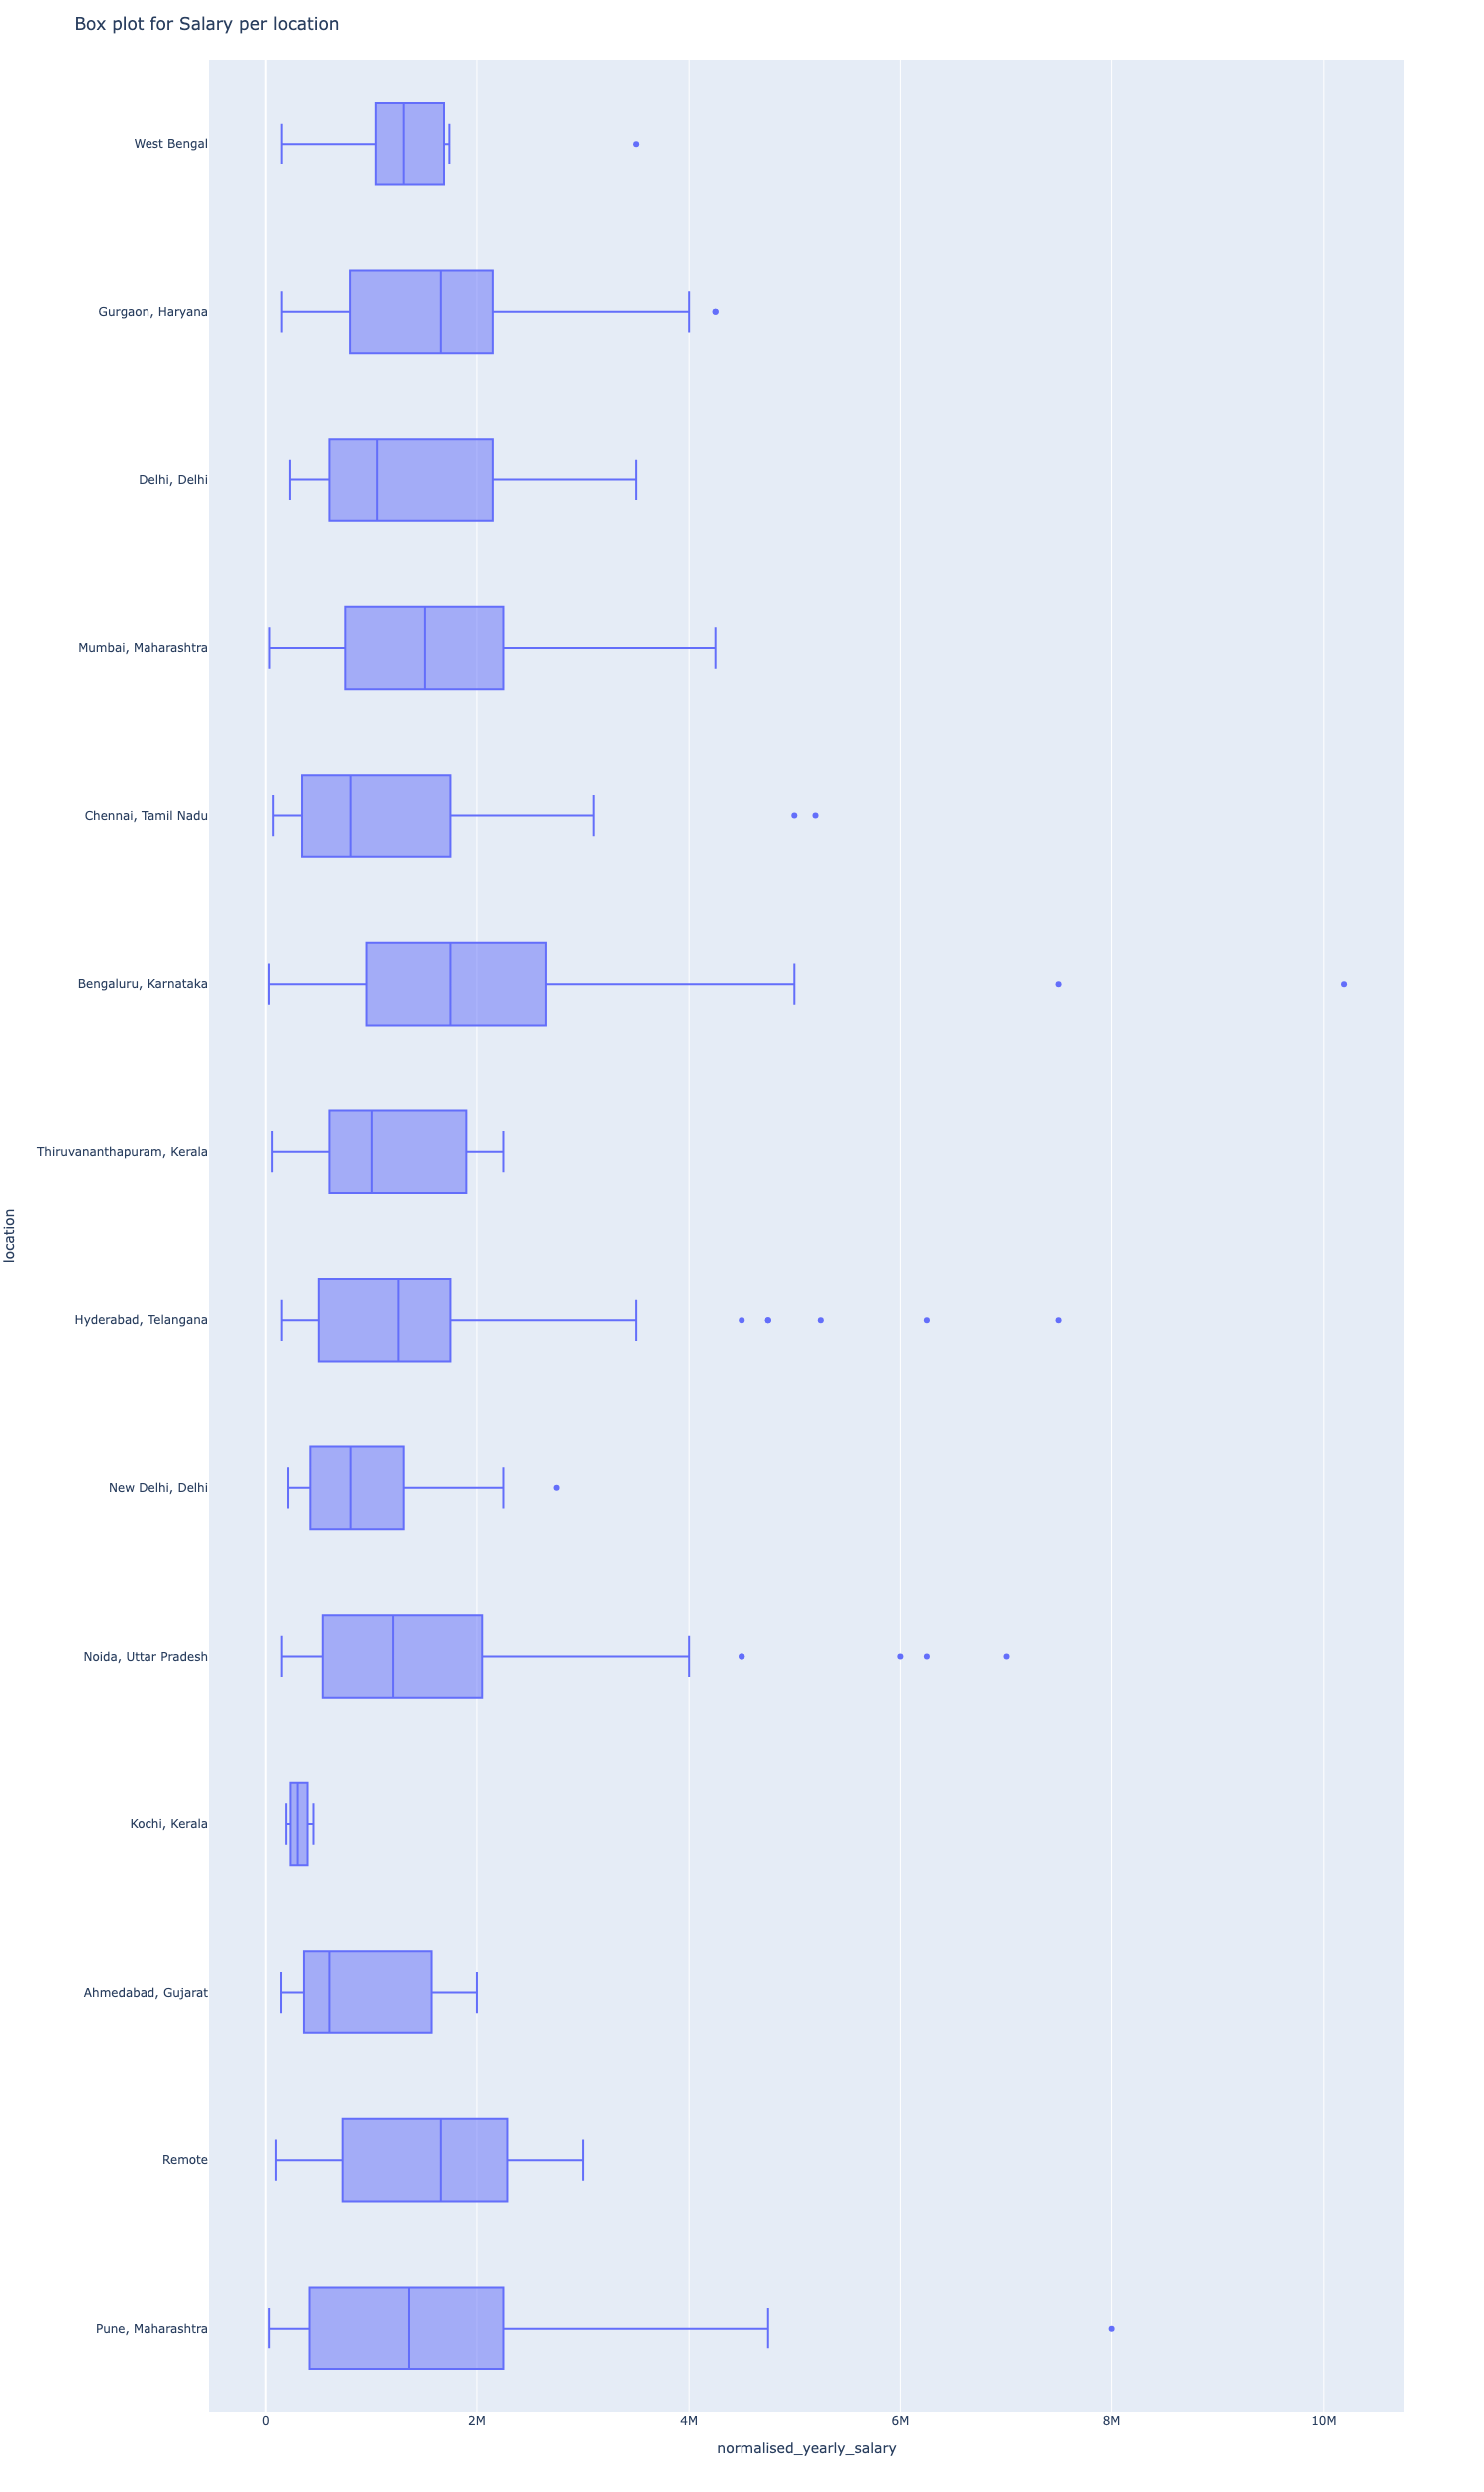

In [484]:
# result_df_copy.info()
import plotly.express as px

result_df_copy.company.value_counts().iloc[:100].index
fig = px.box(result_df_copy,
             x='normalised_yearly_salary', y='location')
fig.update_layout(width=1100, height=2500, title="Box plot for Salary per location")
fig.show()

In [485]:
pd.reset_option('all')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format
exclude = ["vice president", "manager", "officer", "business"]
average_salary = result_df_copy[~result_df_copy["job_title_category"].isin(exclude)].groupby(["job_title_category", "location"], dropna=True).agg({"normalised_yearly_salary": 'mean'}).dropna()

/var/folders/fq/t1vhfgh95v33mglpnsqgnyyh0000gq/T/ipykernel_25065/2069298371.py:1: FutureWarning:

column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.

/var/folders/fq/t1vhfgh95v33mglpnsqgnyyh0000gq/T/ipykernel_25065/2069298371.py:1: FutureWarning:

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

/var/folders/fq/t1vhfgh95v33mglpnsqgnyyh0000gq/T/ipykernel_25065/2069298371.py:1: FutureWarning:


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.




In [475]:
average_salary.sort_values(by='normalised_yearly_salary', ascending=False).head(50)

normalised_yearly_salary
job_title_category               location                                            
automation engineer              Bengaluru, Karnataka                     10200000.00
machine learning                 Pune, Maharashtra                         6375000.00
solution architect               Bengaluru, Karnataka                      4500000.00
machine learning engineer        Gurgaon, Haryana                          3600000.00
technology or technical          Delhi, Delhi                              3500000.00
engineer                         West Bengal                               3500000.00
devops                           Mumbai, Maharashtra                       3500000.00
data architect                   Bengaluru, Karnataka                      3233333.33
artificial intelligence          Gurgaon, Haryana                          3050000.00
data scientist                   Hyderabad, Telangana                      3035714.29
data science                     Delhi, Delhi                              3000000.00
software engineer                Gurgaon, Haryana                          2750000.00
data architect                   Pune, Maharashtra                         2750000.00
lead                             Mumbai, Maharashtra                       2650000.00
data scientist                   Pune, Maharashtra                         2630000.00
technology or technical          Noida, Uttar Pradesh                      2630000.00
data architect                   Hyderabad, Telangana                      2575000.00
data scientist                   Noida, Uttar Pradesh                      2494000.00
data science                     Bengaluru, Karnataka                      2454000.00
technology or technical          Bengaluru, Karnataka                      2363505.17
architect                        Gurgaon, Haryana                          2333333.33
analyst                          Remote                                    2300000.00
technology or technical          Hyderabad, Telangana                      2280000.00
machine learning                 Chennai, Tamil Nadu                       2200000.00
data scientist                   Mumbai, Maharashtra                       2166666.67
machine learning engineer        Mumbai, Maharashtra                       2100000.00
data scientist                   Bengaluru, Karnataka                      2053730.29
data science                     Ahmedabad, Gujarat                        2000000.00
artificial intelligence engineer Gurgaon, Haryana                          2000000.00
engineer                         Gurgaon, Haryana                          2000000.00
analyst                          Bengaluru, Karnataka                      1962560.29
architect                        Pune, Maharashtra                         1956386.50
data science                     Gurgaon, Haryana                          1900000.00
                                 Remote                                    1900000.00
market                           Hyderabad, Telangana                      1900000.00
analyst                          Thiruvananthapuram, Kerala                1900000.00
consult                          Mumbai, Maharashtra                       1868217.21
data scientist                   Chennai, Tamil Nadu                       1864000.00
engineer                         Remote                                    1854250.00
data scientist                   Remote                                    1850000.00
machine learning                 Bengaluru, Karnataka                      1800000.00
lead                             Remote                                    1783000.00
software engineer                Remote                                    1750000.00
analyst                          Noida, Uttar Pradesh                      1750000.00
solution architect               Remote                                    1750000.00
developer          

## Ideal Job Selection

From the above plots, We can see Bangaluru pays highest amoung all jobs and we can also see very high amount of outliers with high salary. We can also see Pune and Hyderabad having high value salary as outliers. I would prefer either Bangaluru or Hyderabad as it shows more outliers. High outliers may indicate opportunities for individuals to achieve higher salaries through career progression, skill development, or taking on more responsibilities.

In [496]:
result_df_copy["description_clean"] = result_df_copy["Description"].apply(clean_text)

In [508]:
pd.set_option('display.max_colwidth', 50)
focued_jobs = result_df_copy[result_df_copy["location"]=="Bengaluru, Karnataka"][~result_df_copy["job_title_category"].isin(exclude)]
focued_jobs.sort_values(by=['rating', 'company'], ascending=False).head(50)

/var/folders/fq/t1vhfgh95v33mglpnsqgnyyh0000gq/T/ipykernel_25065/4218397405.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



job_title  \
2240                                    ML Engineer III   
3173                            Senior Business Analyst   
1184                                     Data Scientist   
1676                               Full Stack Developer   
1097       Data Science - AI/ML with Big data Architect   
1337                         Data Scientist –Technology   
2933                RPA Developer (Automation Anywhere)   
2934                             RPA Developer (UiPath)   
3433                                 Senior ML Engineer   
3287                              Senior Data Scientist   
429                   Azure BI Engineer(Azure+Power BI)   
3673                 Senior Software Engineer - Backend   
1598                             Environmental Modeller   
3405                       Senior Java Backend Engineer   
3692             Senior Software Engineer -( JAVA -AWS)   
3700       Senior Software Engineer(NSG-Firewall C/C++)   
3870             Software Engineer (C& Linux- Firewall)   
2578  Performance Engineer SMTS/LMTS/PMTS - Salesfor...   
3978                    Software Engineering LMTS-AI/ML   
4003                   Software Quality Engineering MTS   
1473         Director Engineering, Site Lead, Core Data   
3779                     Silicon Software Test Engineer   
3938        Software Engineer II, Machine Learning, Geo   
3957        Software Engineer, Developer Tools, Silicon   
3958  Software Engineer, Machine Learning, Google As...   
3959       Software Engineer, University Graduate, 2024   
880                         D&A - Data Domain Architect   
129                                         AWS trainer   
351   Associate Director, Analytics Application Engi...   
2027  Lead Analytics Application Engineer (Backend E...   
2201                    Lead, Machine Learning Engineer   
3108                            Senior AI ML Consultant   
3745         Senior Technical Consultant - AJO/Campaign   
37    AI Cyber-security & Penetration Testing Specia...   
38            AI Cyber-security and Compliance Engineer   
619      Business Processes Consultant - SAP iRPA (ASC)   
1710      Full Stack Software Developer - Python, GenAI   
237                         Architect - GPU Performance   
242    Architect, Performance Verification and Analysis   
3155                Senior Audio Framework Engineer TSE   
3419                      Senior Layout Design Engineer   
3572          Senior Python Software Engineer, Security   
3676     Senior Software Engineer - Distributed Systems   
3719             Senior Solution Architect - Healthcare   
3740  Senior System Software Engineer, Programmable ...   
4006                 Software Technical Program Manager   
4361  System Software Architect, Programmable Vision...   
3681         Senior Software Engineer - JAVA Full Stack   
226                                   Applied Scientist   
719                                     Cloud Architect   

                                 company              location  \
2240                              Turing  Bengaluru, Karnataka   
3173                             CoinDCX  Bengaluru, Karnataka   
1184                      Curl Analytics  Bengaluru, Karnataka   
1676                      Curl Analytics  Bengaluru, Karnataka   
1097                     Anlage Infotech  Bengaluru, Karnataka   
1337                     Anlage Infotech  Bengaluru, Karnataka   
2933           TAO The Automation Office  Bengaluru, Karnataka   
2934           TAO The Automation Office  Bengaluru, Karnataka   
3433                          SymphonyAI  Bengaluru, Karnataka   
3287                  Scienaptic Systems  Bengaluru, Karnataka   
429                    Infiniti Research  Bengaluru, Karnataka   
3673                       Digital Green  Bengaluru, Karnataka   
1598                                Yara  Bengaluru, Karnataka   
3405                              Sophos  Bengaluru, Karnataka   
3692                              Sophos  Beng

We can also see that the Turing, CoinDCX, Curl Analytics, Anlage Infotech, TAO The Automation Office, SymphonyAI, Scienaptic Systems, Infiniti Research, Digital Green, Yara, Sophos, Salesforce, Google, Elixir Consulting, EXCELUS LEARNING SOLUTIONS PVT LTD, Bain & Company, Adobe, SAP, NVIDIA, NEC Software Solutions and Microsoft is having the highest ratings from other users. This might show the trust these company have with the public. 

I will conclude that the ideal job is **Software Engineer, Machine Learning, Google Assistant** (ID:3958) from **Google**. But If I ony consider the jobs for which salary is given, then I will choose **Data Science - AI/ML with Big data Architect** (ID: 1097) from **Anlage Infotech** company. 

In [1]:
import plotly.io as pio
pio.renderers.default = "jupyterlab"